# AP-1 RNA-seq Analysis

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2


In [2]:
### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
import sklearn
from sklearn import preprocessing
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from matplotlib_venn import venn3, venn2
import pickle
from matplotlib import patches as mpatches
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set_context('notebook')

## Preprocessing

In [157]:
# file directories
workingDirectory = '/home/jtao/analysis/ap1_rna_analysis/'
binDirectory = '/home/jtao/bin/'
genomePath = '/bioinformatics/homer/data/genomes/mm10'
genomes = ['hg19','mm10', 'hg38']
peakDirectory = workingDirectory + 'peaks/'
scratchDirectory = workingDirectory + '/scratch/'
logFilePath = workingDirectory + '/log_files/'
tagDirPath = '/home/jtao/analysis/ap1_analysis/tag_directories_rna/'
inputDirectory = workingDirectory + '/input/'
idrDirectory = workingDirectory + '/idr/'

os.chdir(workingDirectory)

In [158]:
strains = []
treatments = []
owners = []
dates = []
originalNames = []
targets = []
for f in os.listdir('./tag_directories/'):
    if os.path.isdir(tagDirPath+'/'+f):
        originalName = f
        metaDataTokens = f.split('_')

        originalNames.append(originalName)
        # grab metadata from string tokens
        strain = metaDataTokens[0].strip()
        target = metaDataTokens[4].strip()
        treatment = metaDataTokens[3].strip()
        owner = metaDataTokens[5].strip()
        date = metaDataTokens[6].strip()

        # append to overall lists
        strains.append(strain)
        treatments.append(treatment)
        owners.append(owner)
        dates.append(date)
        targets.append(target)
metadata_frame = pd.DataFrame([strains, 
                                  targets,
                                  treatments, 
                                  owners, 
                                  originalNames, 
                                  ]).transpose()
metadata_frame.columns = ['strain', 
                          'target',
                         'treatment',
                         'owner', 
                         'sampleName']

# ### read in log files ###

# create data frame summarizing mapping quality logs

# # from tagInfo.txt
_originalNames =[]
_totalReads = []
_fragmentLengthEstimate =[]
_peakSizeEstimate = []
_tagsPerBP = []
_averageTagsPerPosition = []
_averageTagLength = []
_averageFragmentGCcontent = []


for tagdir in os.listdir('./tag_directories/'):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        _originalNames.append(tagdir)
        _fragmentLengthEstimate.append(float(data[2].strip().split('=')[1]))
        _peakSizeEstimate.append(float(data[3].strip().split('=')[1]))
        _tagsPerBP.append(float(data[4].strip().split('=')[1]))
        _averageTagsPerPosition.append(float(data[5].strip().split('=')[1]))
        _averageTagLength.append(float(data[6].strip().split('=')[1]))
        _averageFragmentGCcontent.append(float(data[8].strip().split('=')[1]))
        _totalReads.append(float(data[1].split()[2]))
mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 

                                   _fragmentLengthEstimate,
                                   _peakSizeEstimate,
                                   _tagsPerBP,
                                   _averageTagsPerPosition,
                                   _averageTagLength,
                                   _averageFragmentGCcontent,
                                  ]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'fragmentLengthEstimate',
                              'peakSizeEstimate',
                              'tagsPerBP',
                              'averageTagsPerPosition',
                              'averageTagLength',
                              'averageFragmentGCcontent']

summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')


summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values),
                                                  list(summary_frame['target'].values),
                                                  list(summary_frame['treatment'].values)])
summary_frame = summary_frame.sort()
summary_frame.to_csv('qc_metrics_rna.tsv', sep='\t', index=False)
summary_frame_rna = summary_frame.copy()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: FutureWarning: sort(....) is deprecated, use sort_index(.....)


## Mapping Quality Control

### Plot Distributions of Mapping Statistics

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


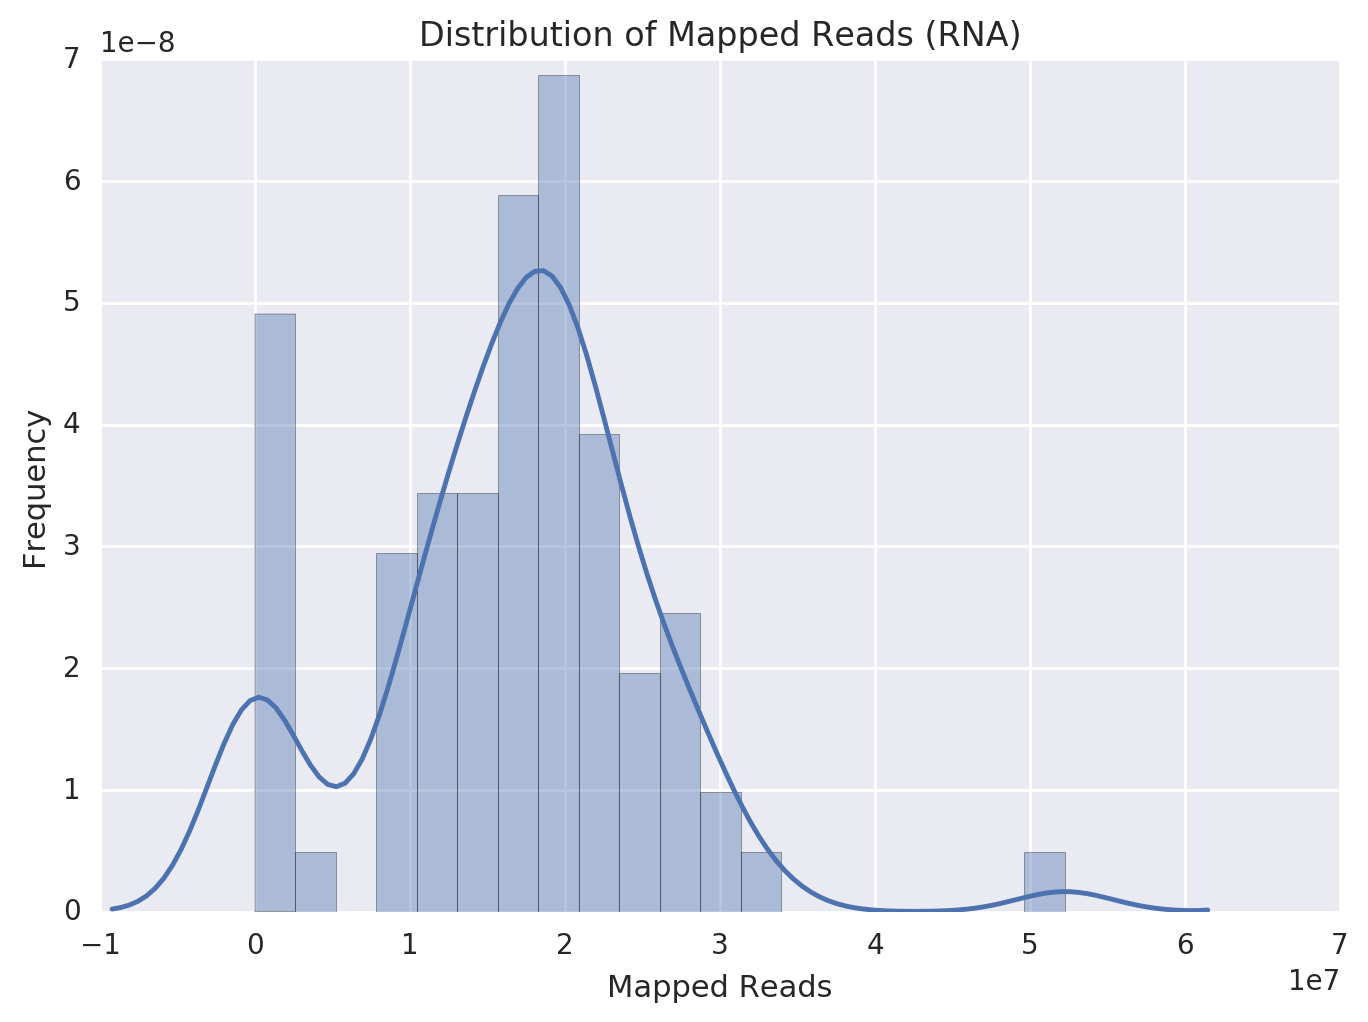

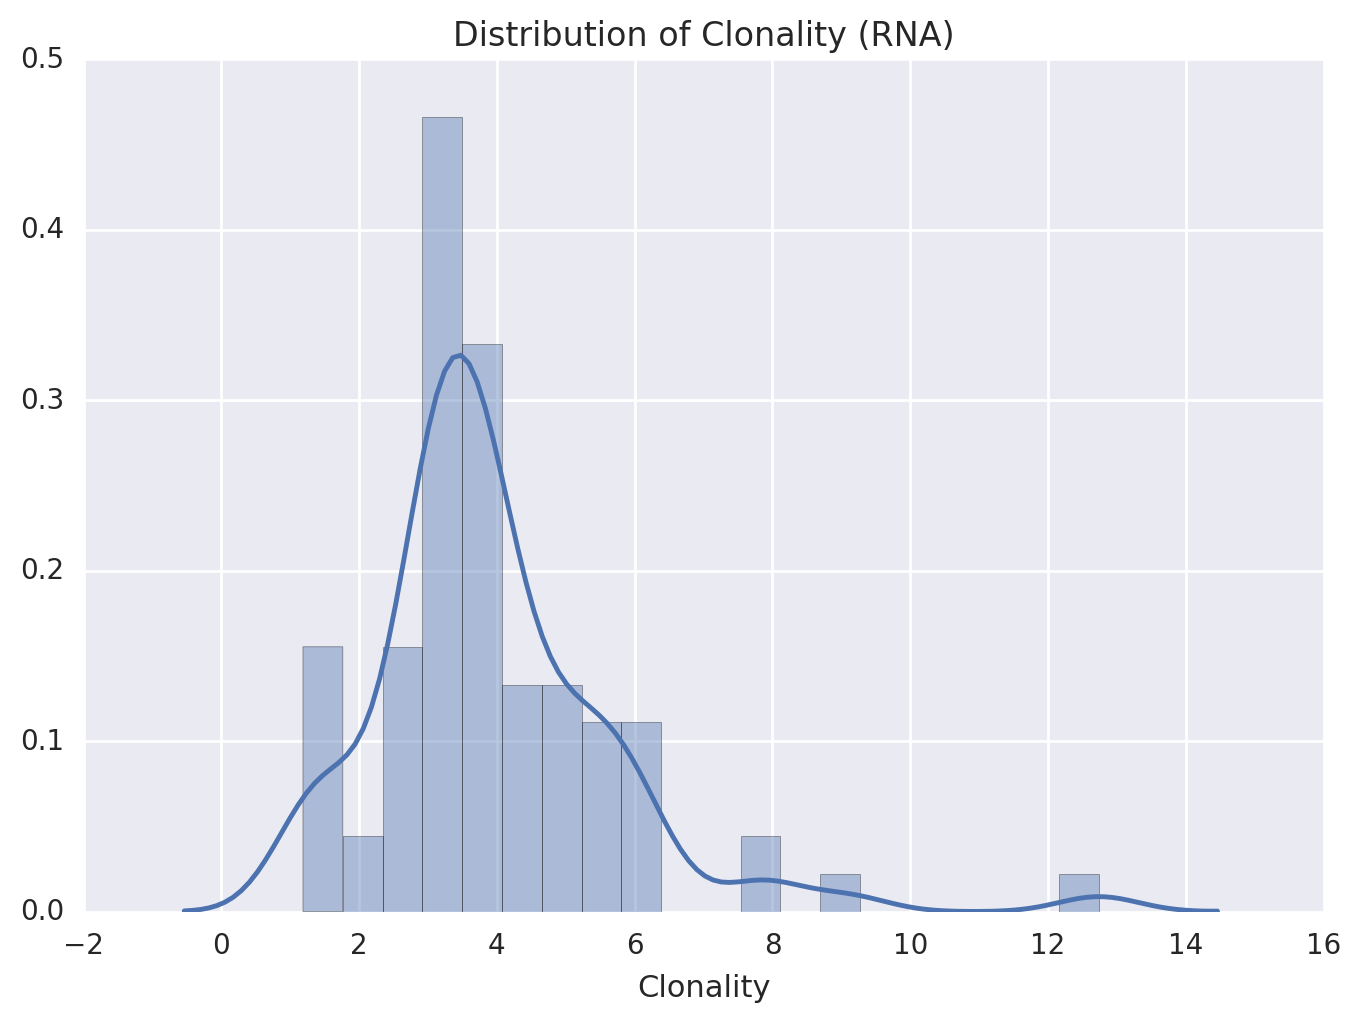

In [159]:
sns.distplot(summary_frame_rna['totalReads'], bins=20, kde=True)
plt.title('Distribution of Mapped Reads (RNA)')
plt.xlabel('Mapped Reads')
plt.ylabel('Frequency')
plt.show()

sns.distplot(summary_frame_rna['averageTagsPerPosition'], bins=20)
plt.title('Distribution of Clonality (RNA)')
plt.xlabel('Clonality')
plt.show()


### Filter Samples According to Mapping Quality

In [161]:
# # filter samples according to threshold for the fraction of uniquely mapped reads
readsThreshold = 5000000
# # pbcThreshold=0.0
# # gcThreshold=0.10
clonalityThreshold = 10
# # spotThreshold = 0.005

filtered_summary_frame_rna = summary_frame_rna.copy()

filtered_summary_frame_rna = filtered_summary_frame_rna[filtered_summary_frame_rna['totalReads'] >= readsThreshold]

filtered_summary_frame_rna = filtered_summary_frame_rna[filtered_summary_frame_rna['averageTagsPerPosition'] <= clonalityThreshold]
print(summary_frame_rna.shape, filtered_summary_frame_rna.shape)

(78, 12) (66, 12)


## Calculate Tag Counts and RPKM

In [162]:
filteredTagDirectories = ' '.join(['/home/jtao/analysis/ap1_analysis/tag_directories_rna/' +x for x in filtered_summary_frame_rna['sampleName']])

!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d $filteredTagDirectories > rpkm.tsv
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d $filteredTagDirectories > raw.tsv

	Tag Directories:
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_CR_12-03-09
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_14-12-15
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_15-04-06
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_UT_GFEW_16-02-04
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_VML_15-02-26
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_14-12-15
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_CR_12-03-09
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_15-04-06
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_GFEW_16-02-04
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_siATF3_GJF_16-06-14
		/home/jtao/analysis/a

In [163]:
# read in RPKM values
rpkm_frame = pd.read_csv("rpkm.tsv",sep="\t")
columns = rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
rpkm_frame.columns = columns    
rpkm_frame['gene'] = [x.split("|")[0].upper() for x in rpkm_frame['Annotation/Divergence']]
columns = list(rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_frame = rpkm_frame[columns]
rpkm_frame.index = rpkm_frame['gene'].values

raw_frame = pd.read_csv("raw.tsv",sep="\t")
columns = raw_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "tag_directories" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
raw_frame.columns = columns  
raw_frame['gene'] = [x.split("|")[0].upper() for x in raw_frame['Annotation/Divergence']]
columns = list(raw_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
raw_frame = raw_frame[columns]

refseq_gene_mapping = dict(zip(rpkm_frame['refseq'].values, [x.split("|")[0].upper() for x in rpkm_frame['Annotation/Divergence']]))
gene_refseq_mapping = dict(zip([x.split("|")[0].upper() for x in rpkm_frame['Annotation/Divergence']], rpkm_frame['refseq'].values))
refseq_gene_mapping.update(dict(zip(raw_frame['refseq'].values, [x.split("|")[0].upper() for x in raw_frame['Annotation/Divergence']])))
gene_refseq_mapping.update(dict(zip([x.split("|")[0].upper() for x in raw_frame['Annotation/Divergence']], raw_frame['refseq'].values)))

# get filtered rpkm values
filtered_rpkm_frame =  rpkm_frame[[x for x in rpkm_frame.columns if x in filtered_summary_frame_rna['sampleName'].values]]
# columns = [originalName_simpleName_dict[x] for x in filtered_rpkm_frame.columns.values]
# filtered_rpkm_frame.columns = columns
filtered_rpkm_frame.index = rpkm_frame.refseq.values
# get rid of genes that aren't expressed at all
filtered_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.sum(axis=1) > 1.0]

## Run IDR

In [167]:
# %%capture
idrDirectory = '/home/jtao/analysis/ap1_rna_analysis/idr_rna_raw/'
sampleColumns = raw_frame.columns.values[9:]
originalName_simpleTreatment_dict = dict(zip(filtered_summary_frame_rna['sampleName'], 
                                             filtered_summary_frame_rna['target'] +
                                             '_' + filtered_summary_frame_rna['treatment']))

conditions = " ".join([originalName_simpleTreatment_dict[x] for x in sampleColumns])
!echo "python /home/jtao/code/seq_merge_pipe/run_idr_homerRNA.py raw.tsv $idrDirectory $conditions &"
!python /home/jtao/code/seq_merge_pipe/run_idr_homerRNA.py raw.tsv $idrDirectory $conditions


python /home/jtao/code/seq_merge_pipe/run_idr_homerRNA.py raw.tsv /home/jtao/analysis/ap1_rna_analysis/idr_rna_raw/ UT_KLA-1h UT_KLA-6h UT_KLA-6h UT_KLA-6h UT_Veh UT_Veh UT_Veh UT_Veh UT_Veh siATF3_KLA-6h siATF3_KLA-6h siATF3_Veh siATF3_Veh siATF3_Veh siCtrl_KLA-6h siCtrl_KLA-6h siCtrl_KLA-6h siCtrl_Veh siCtrl_Veh siCtrl_Veh siCtrl_Veh siCtrl1-1_KLA-6h siCtrl1-1_Veh siCtrl1-2_KLA-6h siCtrl1-2_Veh siCtrl2-1_KLA-6h siCtrl2-1_Veh siCtrl2-2_KLA-6h siCtrl2-2_Veh siFos_KLA-6h siFos_KLA-6h siFos_KLA-6h siFos_KLA-6h siFos_Veh siFos_Veh siFos_Veh siFos_Veh siJunB_KLA-6h siJunB_KLA-6h siJunB_KLA-6h siJunB_KLA-6h siJunB_Veh siJunB_Veh siJunB_Veh siJunB_Veh siJunB_Veh siJunD_KLA-6h siJunD_KLA-6h siJunD_KLA-6h siJunD_KLA-6h siJunD_Veh siJunD_Veh siJunD_Veh siJunD_Veh siJunD_Veh sicJun_KLA-6h sicJun_KLA-6h sicJun_KLA-6h sicJun_KLA-6h sicJun_Veh sicJun_Veh sicJun_Veh sicJun_Veh sicJun_Veh UT_Veh UT_Veh &
Output files will be written to: /home/jtao/analysis/ap1_rna_analysis/idr_rna_raw/
Using the foll

In [168]:
# %%capture
idrDirectory = '/home/jtao/analysis/ap1_rna_analysis/idr_rna/'
sampleColumns = raw_frame.columns.values[9:]
originalName_simpleTreatment_dict = dict(zip(filtered_summary_frame_rna['sampleName'], 
                                             filtered_summary_frame_rna['target'] +
                                             '_' + filtered_summary_frame_rna['treatment']))

conditions = " ".join([originalName_simpleTreatment_dict[x] for x in sampleColumns])

!python /home/jtao/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions


Output files will be written to: /home/jtao/analysis/ap1_rna_analysis/idr_rna/
Using the following IDR threshold: 0.05
Performing IDR analysis using the following columns and conditions:
/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_CR_12-03-09 FPKM 	 UT_KLA-1h
/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_14-12-15 FPKM 	 UT_KLA-6h
/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_15-04-06 FPKM 	 UT_KLA-6h
/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_UT_GFEW_16-02-04 FPKM 	 UT_KLA-6h
/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_VML_15-02-26 FPKM 	 UT_Veh
/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_14-12-15 FPKM 	 UT_Veh
/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_CR_12-03-09 FPKM 	 UT_Veh
/home/jtao/analysis/ap1_analysis/tag_directories

In [169]:
idr_rpkm_frame = pd.read_csv('idr_rna/idr_union.tsv', sep='\t')

columns = idr_rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
idr_rpkm_frame.columns = columns    
idr_rpkm_frame['gene'] = [x.split("|")[0].upper() for x in idr_rpkm_frame['Annotation/Divergence']]
columns = list(idr_rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
idr_rpkm_frame = idr_rpkm_frame[columns]
idr_rpkm_frame.index = idr_rpkm_frame['gene'].values
idr_rpkm_frame = idr_rpkm_frame.ix[:,9:]

idr_rpkm_mean_frame = pd.DataFrame()
treatment_col_dict = {}
for col in idr_rpkm_frame.columns.values:
    tokens = col.split('_')
    target = tokens[4]
    if 'Ctrl'in target:
        target = target[:-3]
    treatment =  tokens[3] + '_' + target

    if not treatment in treatment_col_dict:
        treatment_col_dict[treatment] = [col]
    else:
        treatment_col_dict[treatment].append(col)
for treatment in treatment_col_dict:
    idr_rpkm_mean_frame[treatment] = np.mean(idr_rpkm_frame[treatment_col_dict[treatment]], axis=1)
idr_rpkm_mean_frame = idr_rpkm_mean_frame.sort()

idr_rpkm_mean_frame = idr_rpkm_mean_frame[sorted(idr_rpkm_mean_frame.columns.values)]


idr_rpkm_frame.to_pickle('idr_rpkm_frame.pickle')
idr_rpkm_mean_frame.to_pickle('idr_rpkm_mean_frame.pickle')


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:32: FutureWarning: sort(....) is deprecated, use sort_index(.....)


## Calculate Correlations Between Samples

In [170]:
def calcCorrelation(raw_frame,samples, annot=False):

    numSamples = len(samples)
    matrix = np.ones((numSamples, numSamples))

    for i in range(numSamples - 1):
        vals_1 = raw_frame[samples[i]]
        for j in range(i + 1, numSamples):
            vals_2 = raw_frame[samples[j]]
            pearson, pearson_p = scipy.stats.pearsonr(vals_1, vals_2)

            matrix[i][j] = pearson
            matrix[j][i] = pearson

    sample_names = [x.replace('C57Bl6_Thiomac_RNA_','') for x in samples]
    matrix_frame = pd.DataFrame(matrix, index=sample_names, columns=sample_names)


    cg = sns.clustermap(matrix_frame, metric = 'correlation', figsize=(16,16), annot=annot, fmt='0.2g')
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
    plt.show()
#     return matrix_frame

In [171]:
def calcSpearmanCorrelation(raw_frame,samples, annot=False):

    numSamples = len(samples)
    matrix = np.ones((numSamples, numSamples))

    for i in range(numSamples - 1):
        vals_1 = raw_frame[samples[i]]
        for j in range(i + 1, numSamples):
            vals_2 = raw_frame[samples[j]]
            pearson, pearson_p = scipy.stats.spearmanr(vals_1, vals_2)

            matrix[i][j] = pearson
            matrix[j][i] = pearson

    sample_names = [x.replace('C57Bl6_Thiomac_RNA_','') for x in samples]
    matrix_frame = pd.DataFrame(matrix, index=sample_names, columns=sample_names)


    cg = sns.clustermap(matrix_frame, metric = 'correlation', figsize=(16,16), annot=annot, fmt='0.2g')
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
    plt.show()
#     return matrix_frame

### All Samples

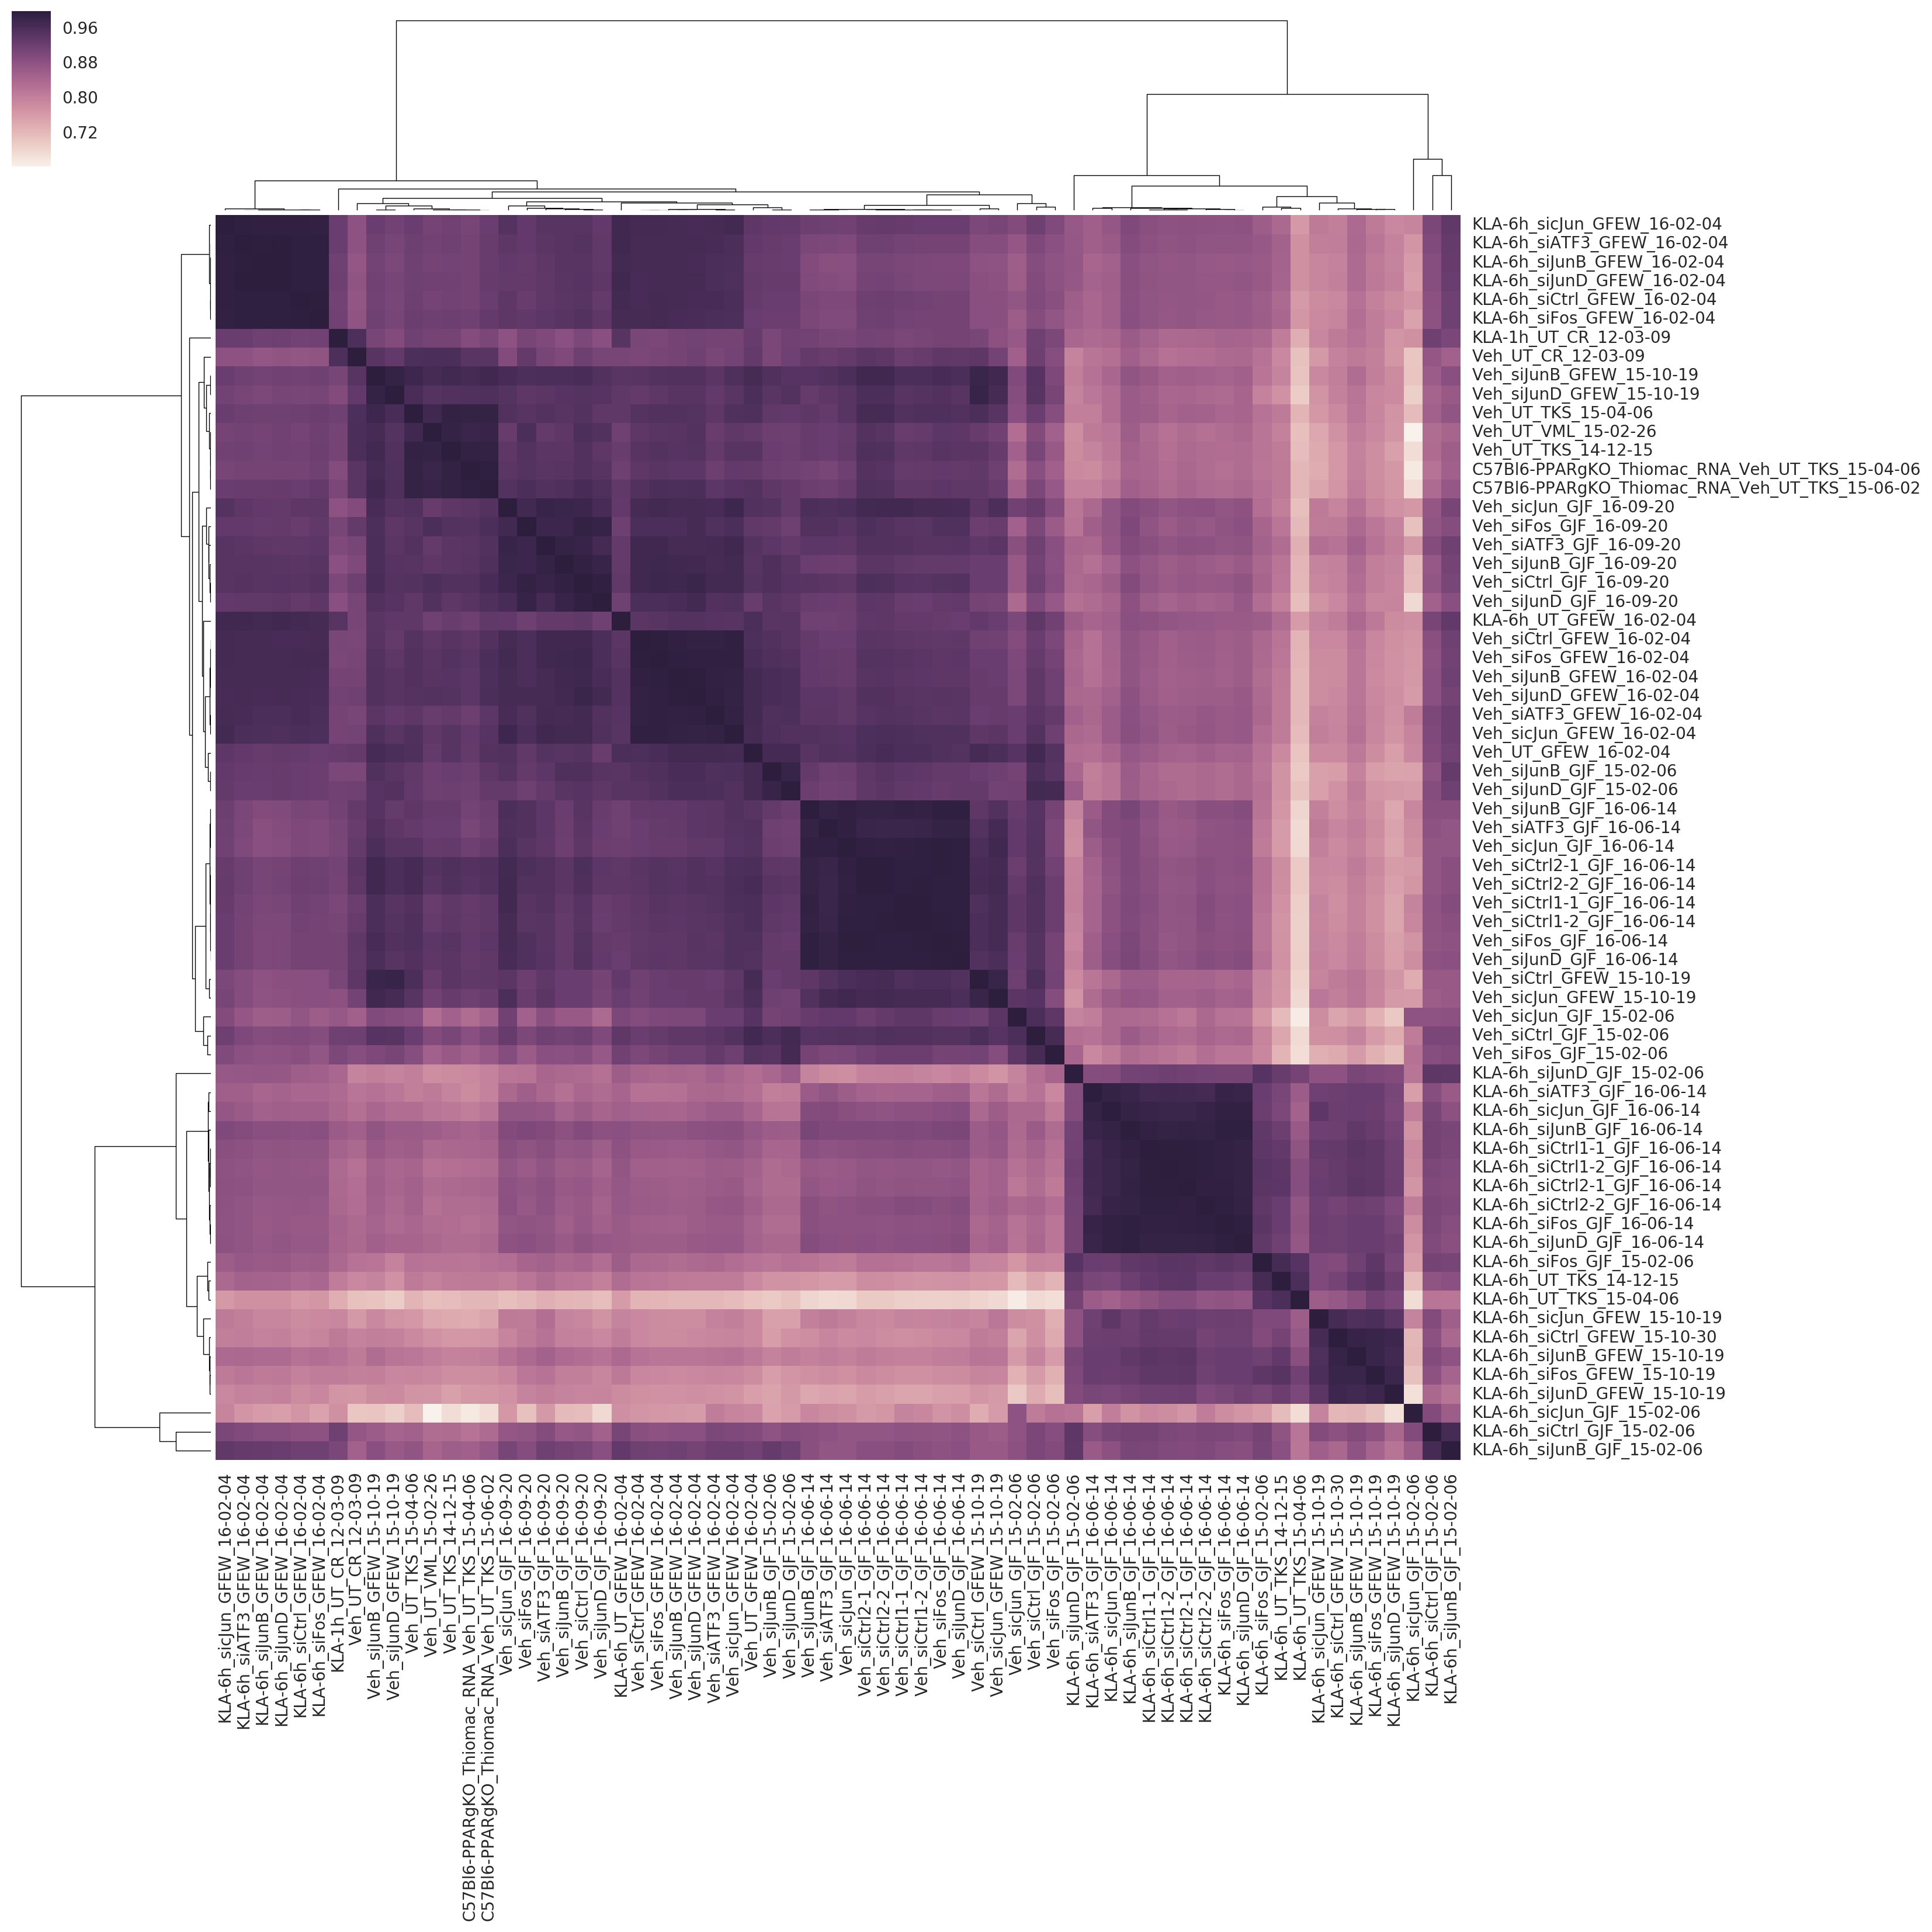

In [172]:
calcCorrelation(raw_frame, raw_frame.columns[9:].values)

### Veh Samples

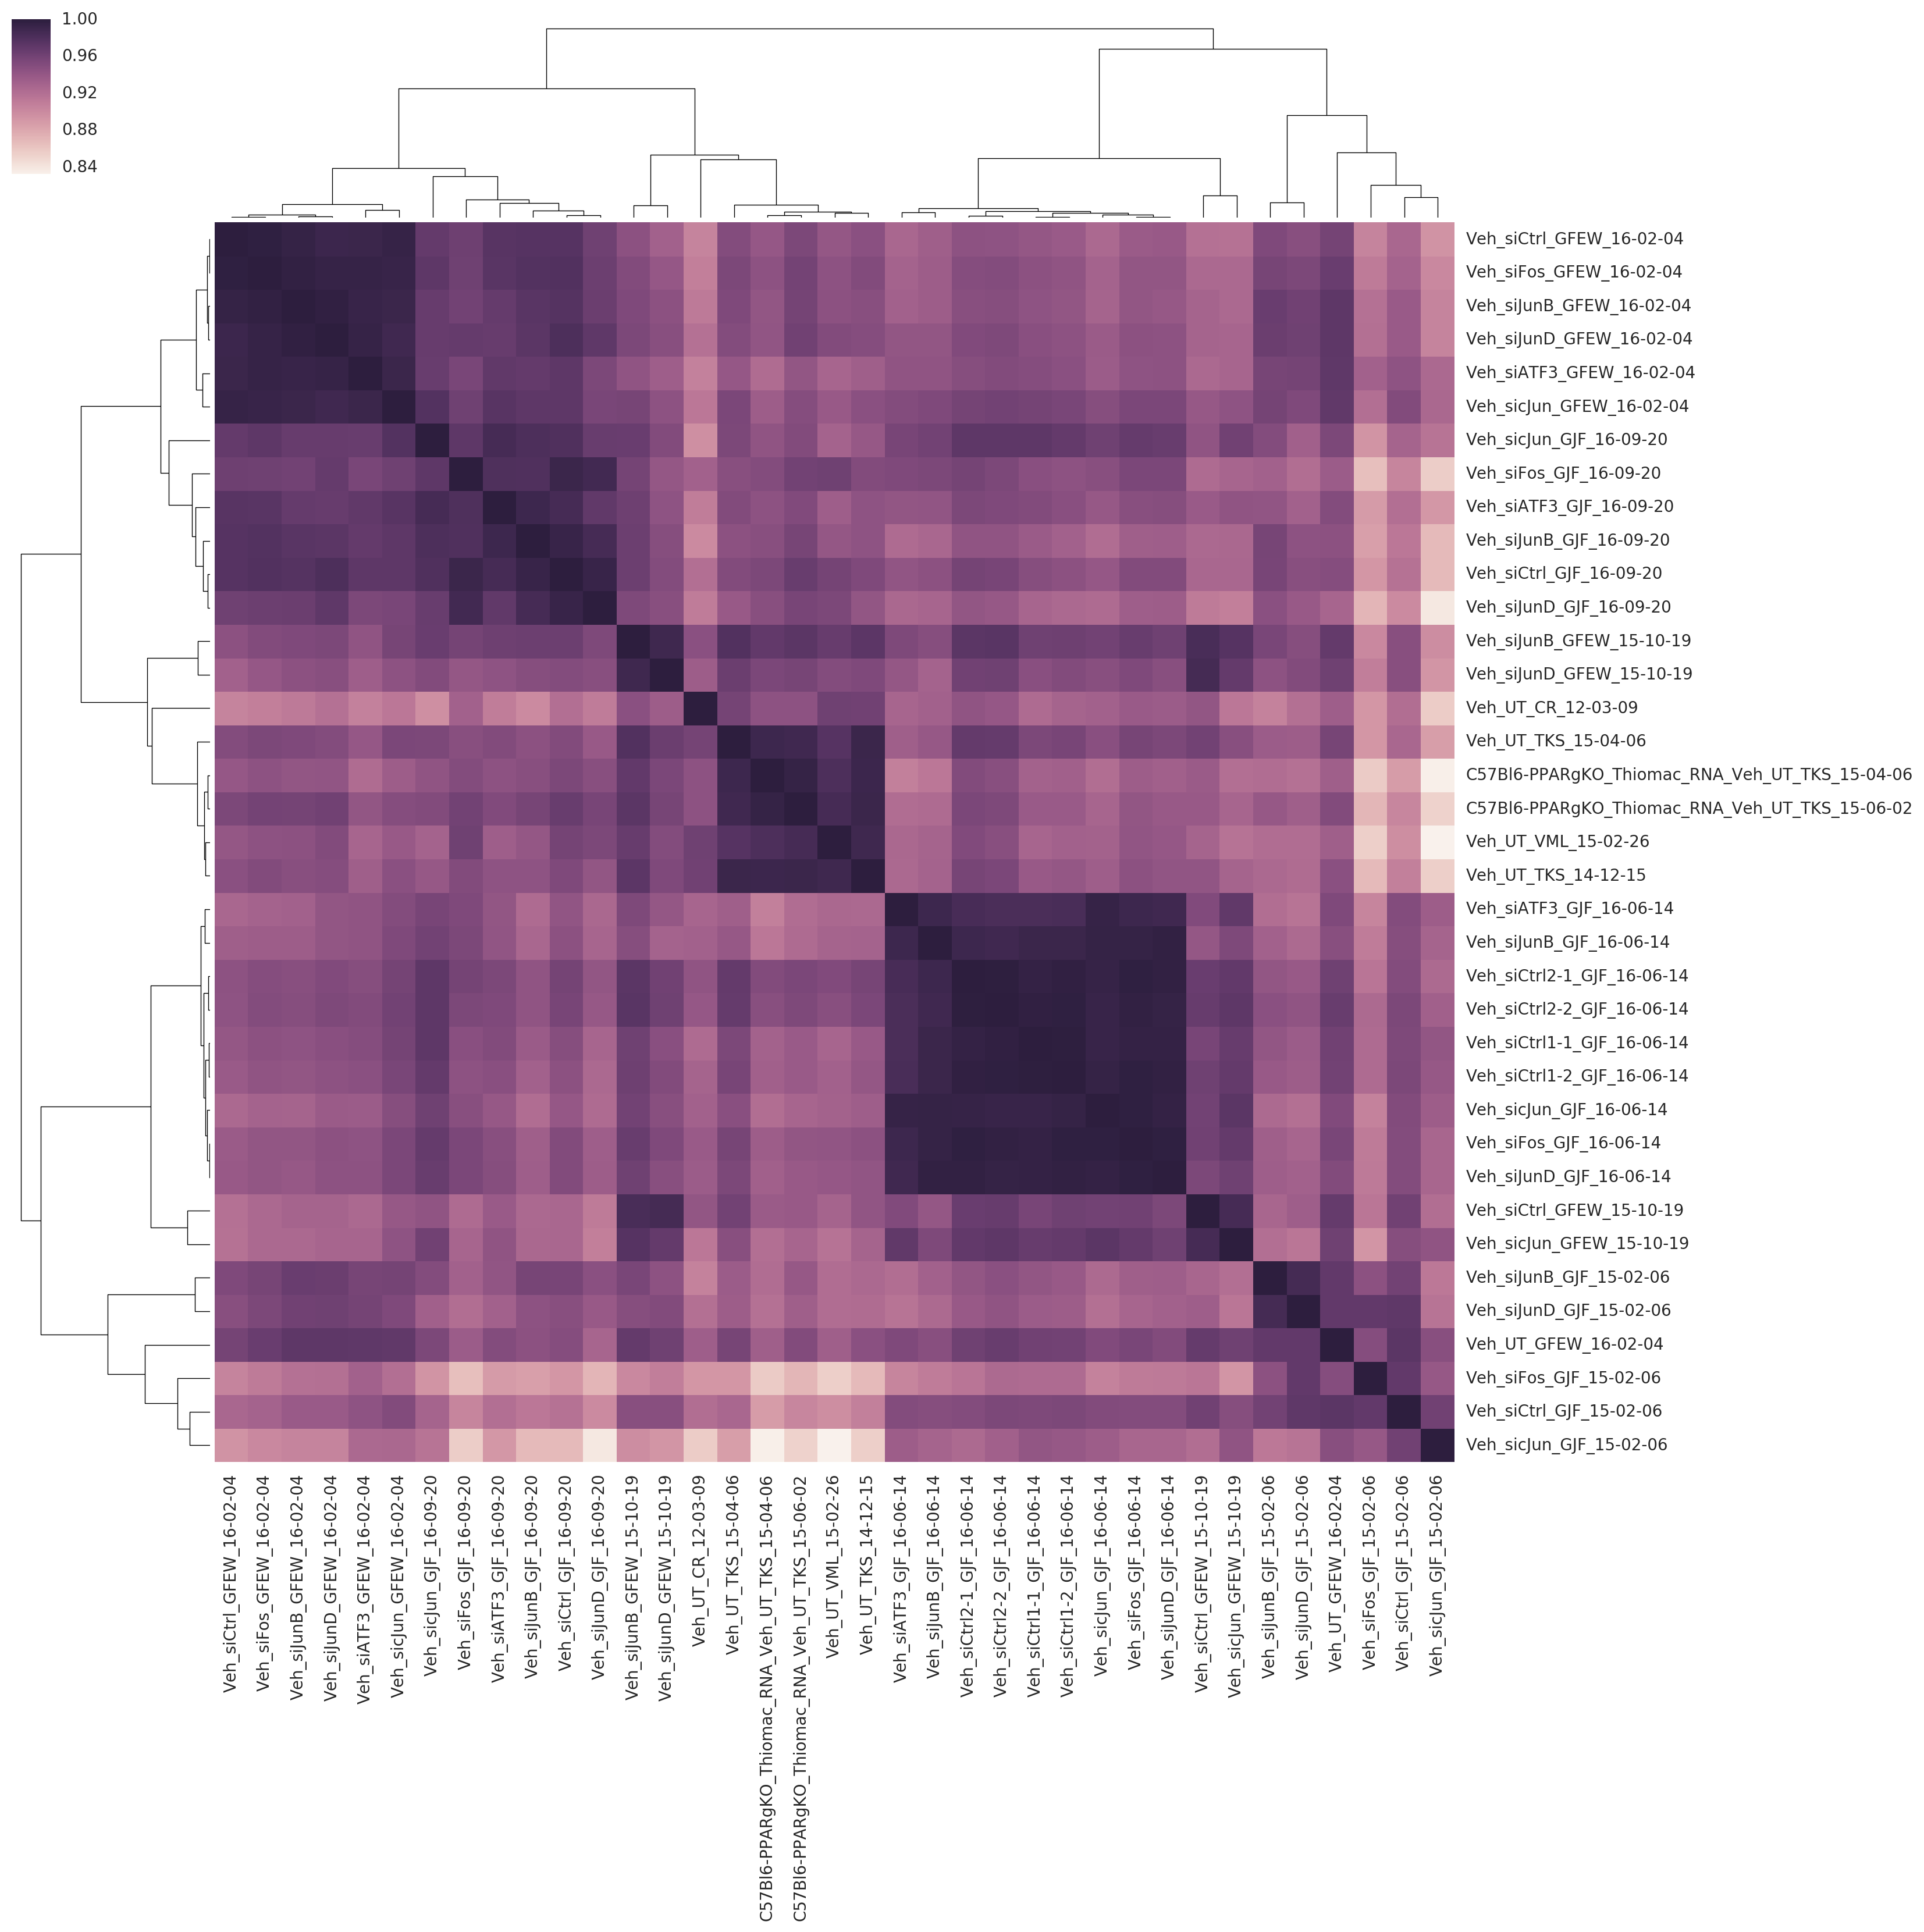

In [173]:
calcCorrelation(raw_frame, [x for x in raw_frame.columns[9:].values if 'Veh' in x])

### KLA Samples

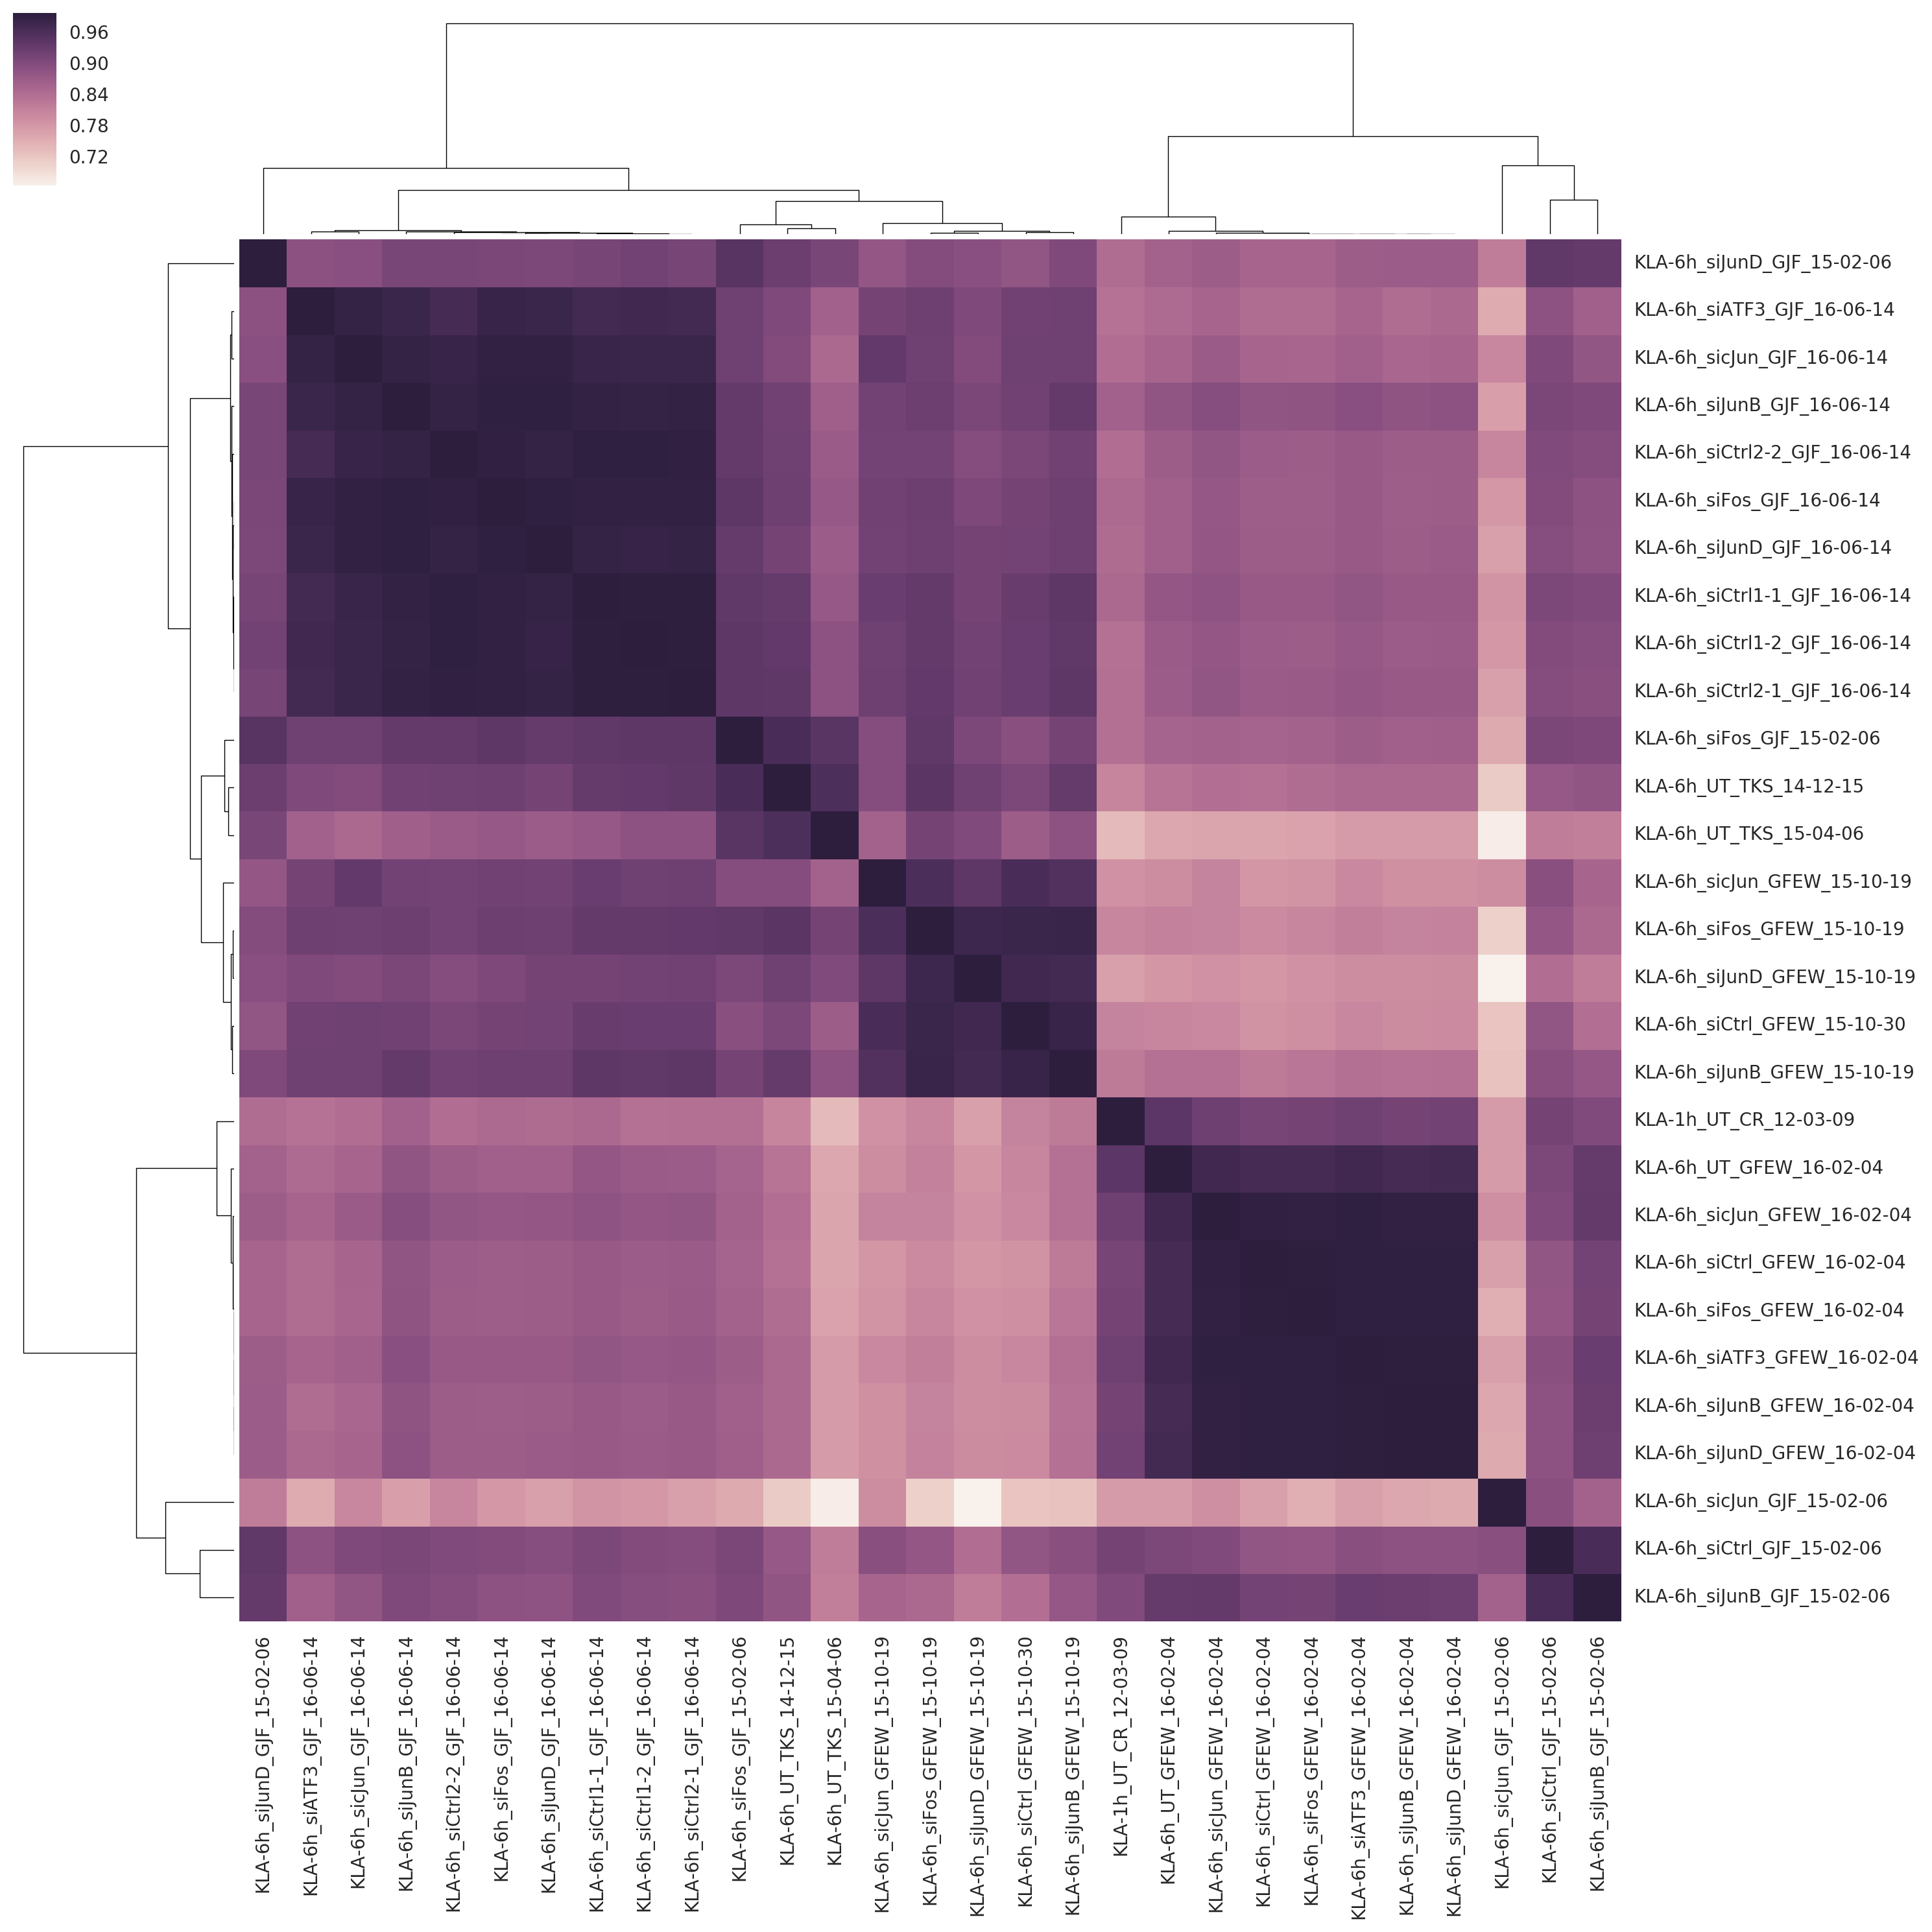

In [174]:
calcCorrelation(raw_frame, [x for x in raw_frame.columns[9:].values if 'KLA' in x])

### Control Samples

#### All

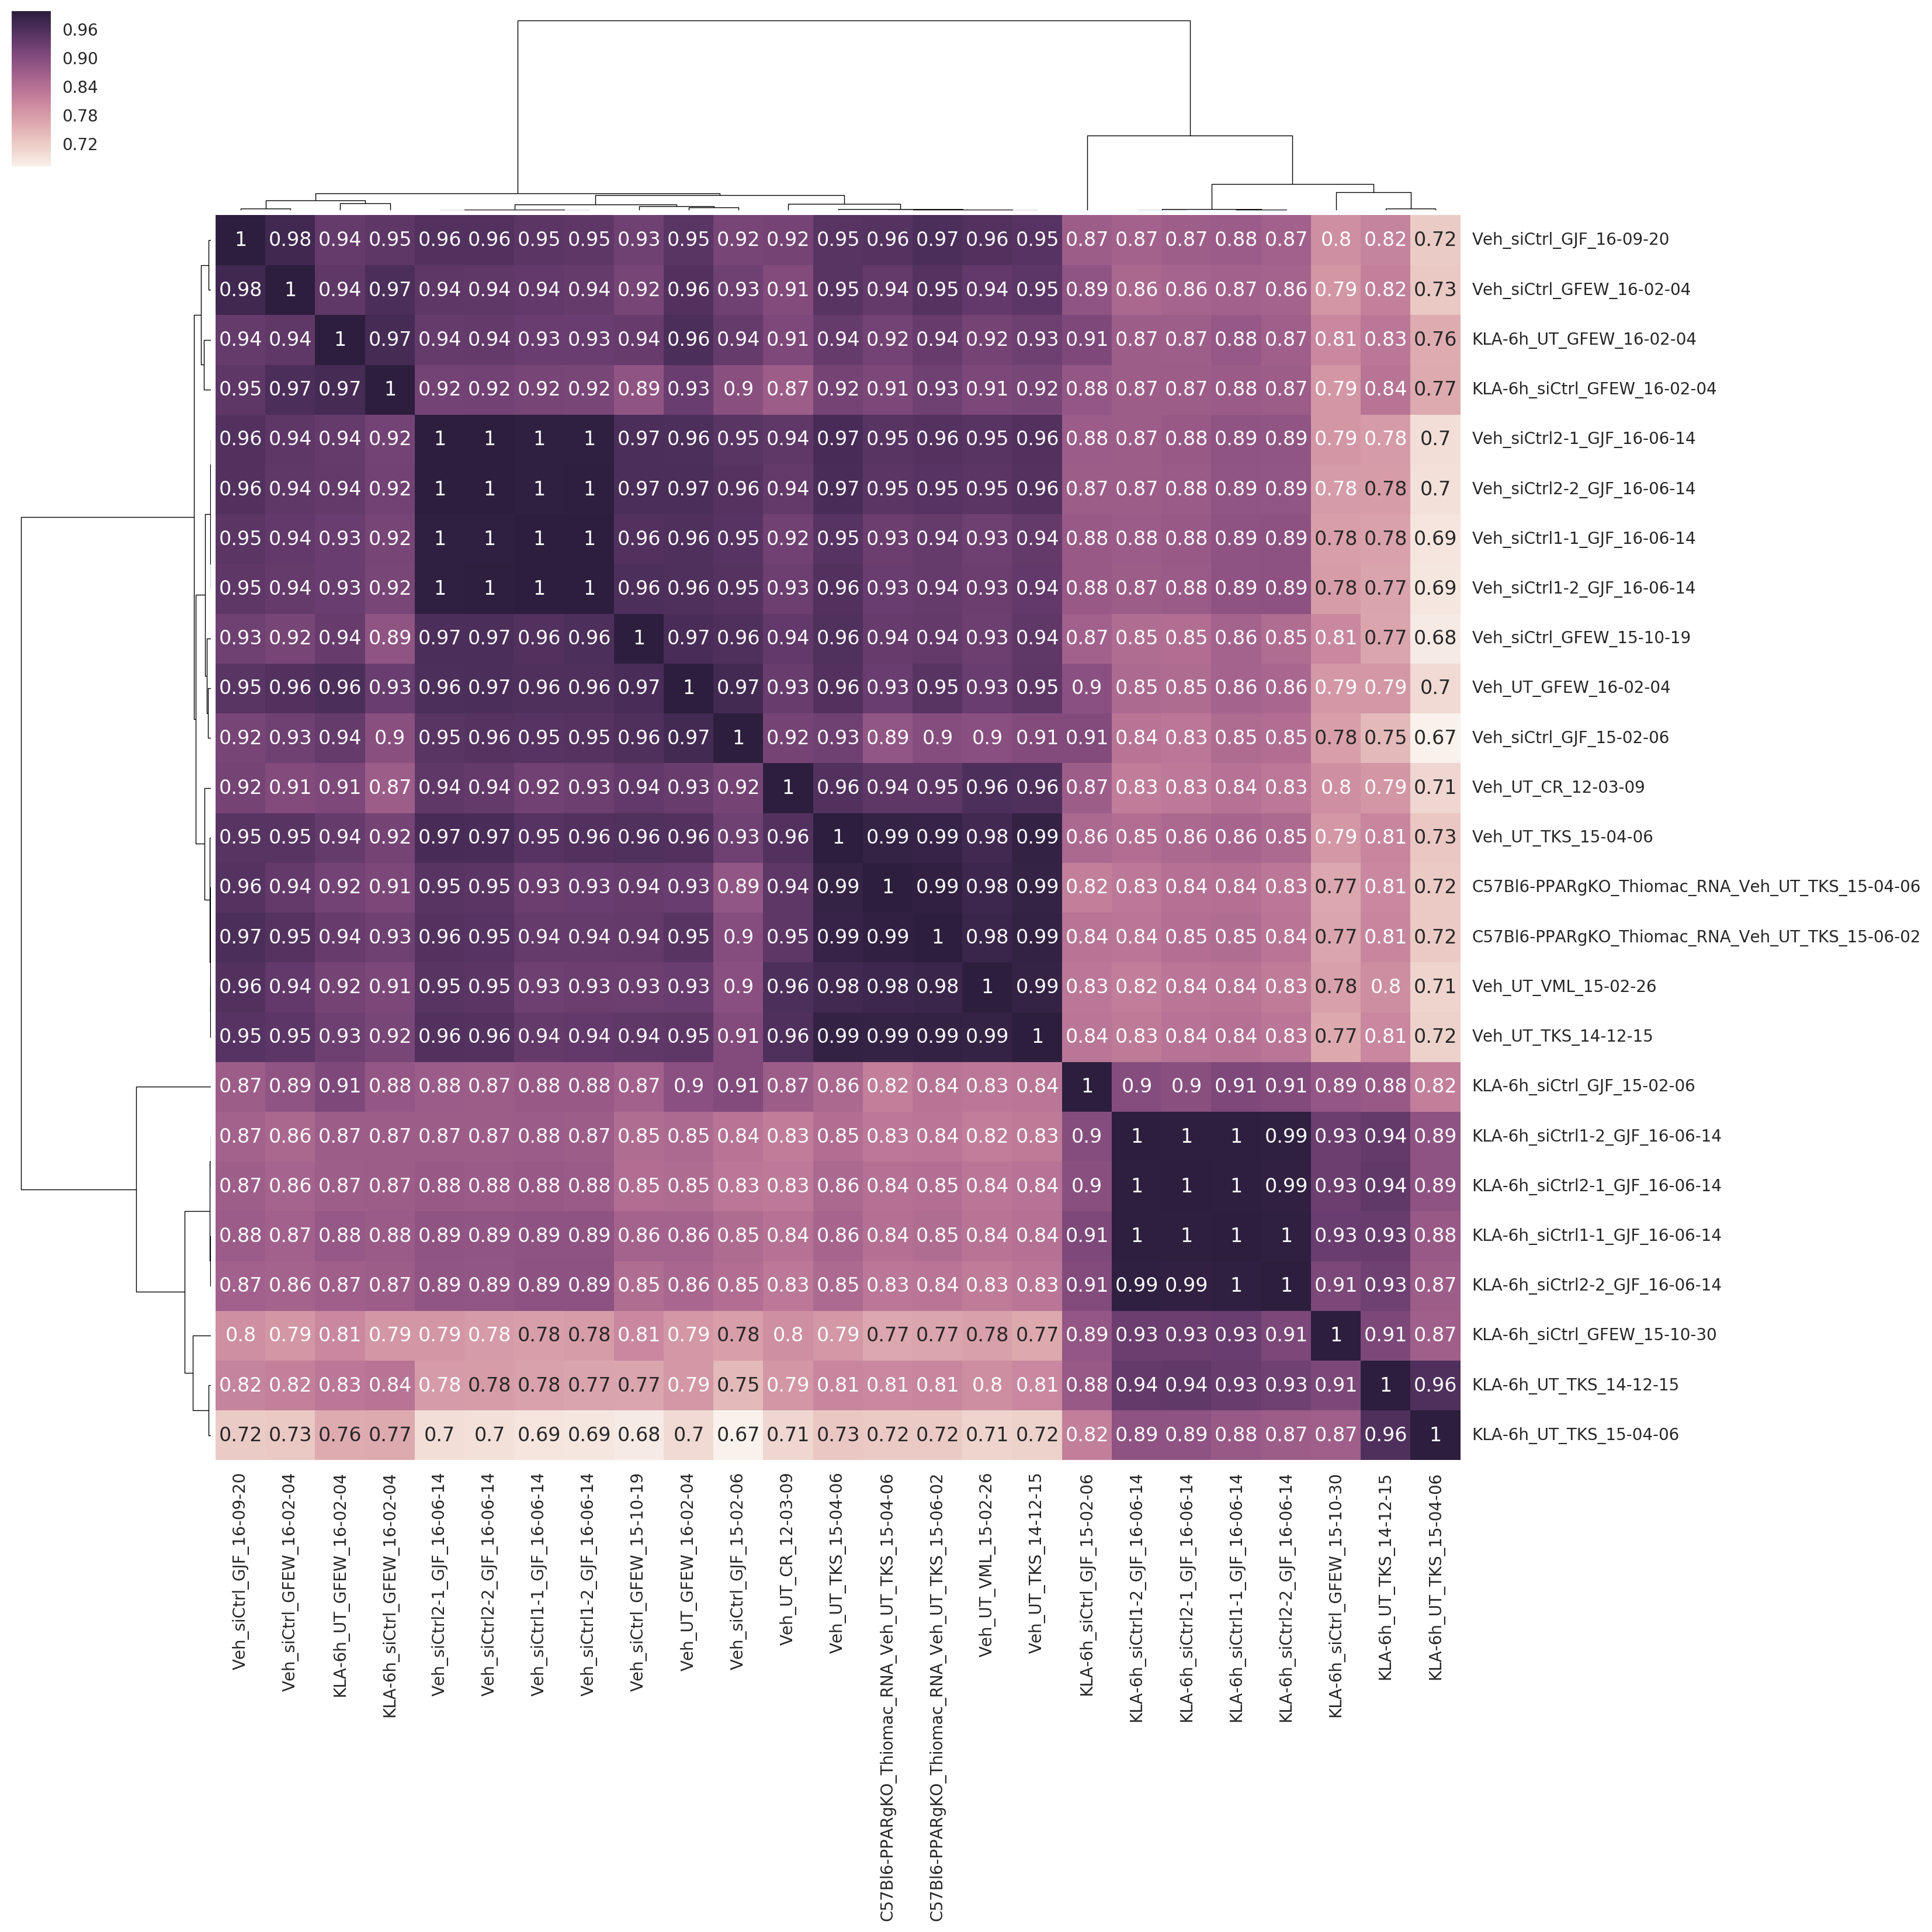

In [175]:
calcCorrelation(raw_frame, 
                [x for x in raw_frame.columns[9:].values if ('Ctrl' in x or 'UT' in x) and not '-1h' in x], 
                True)

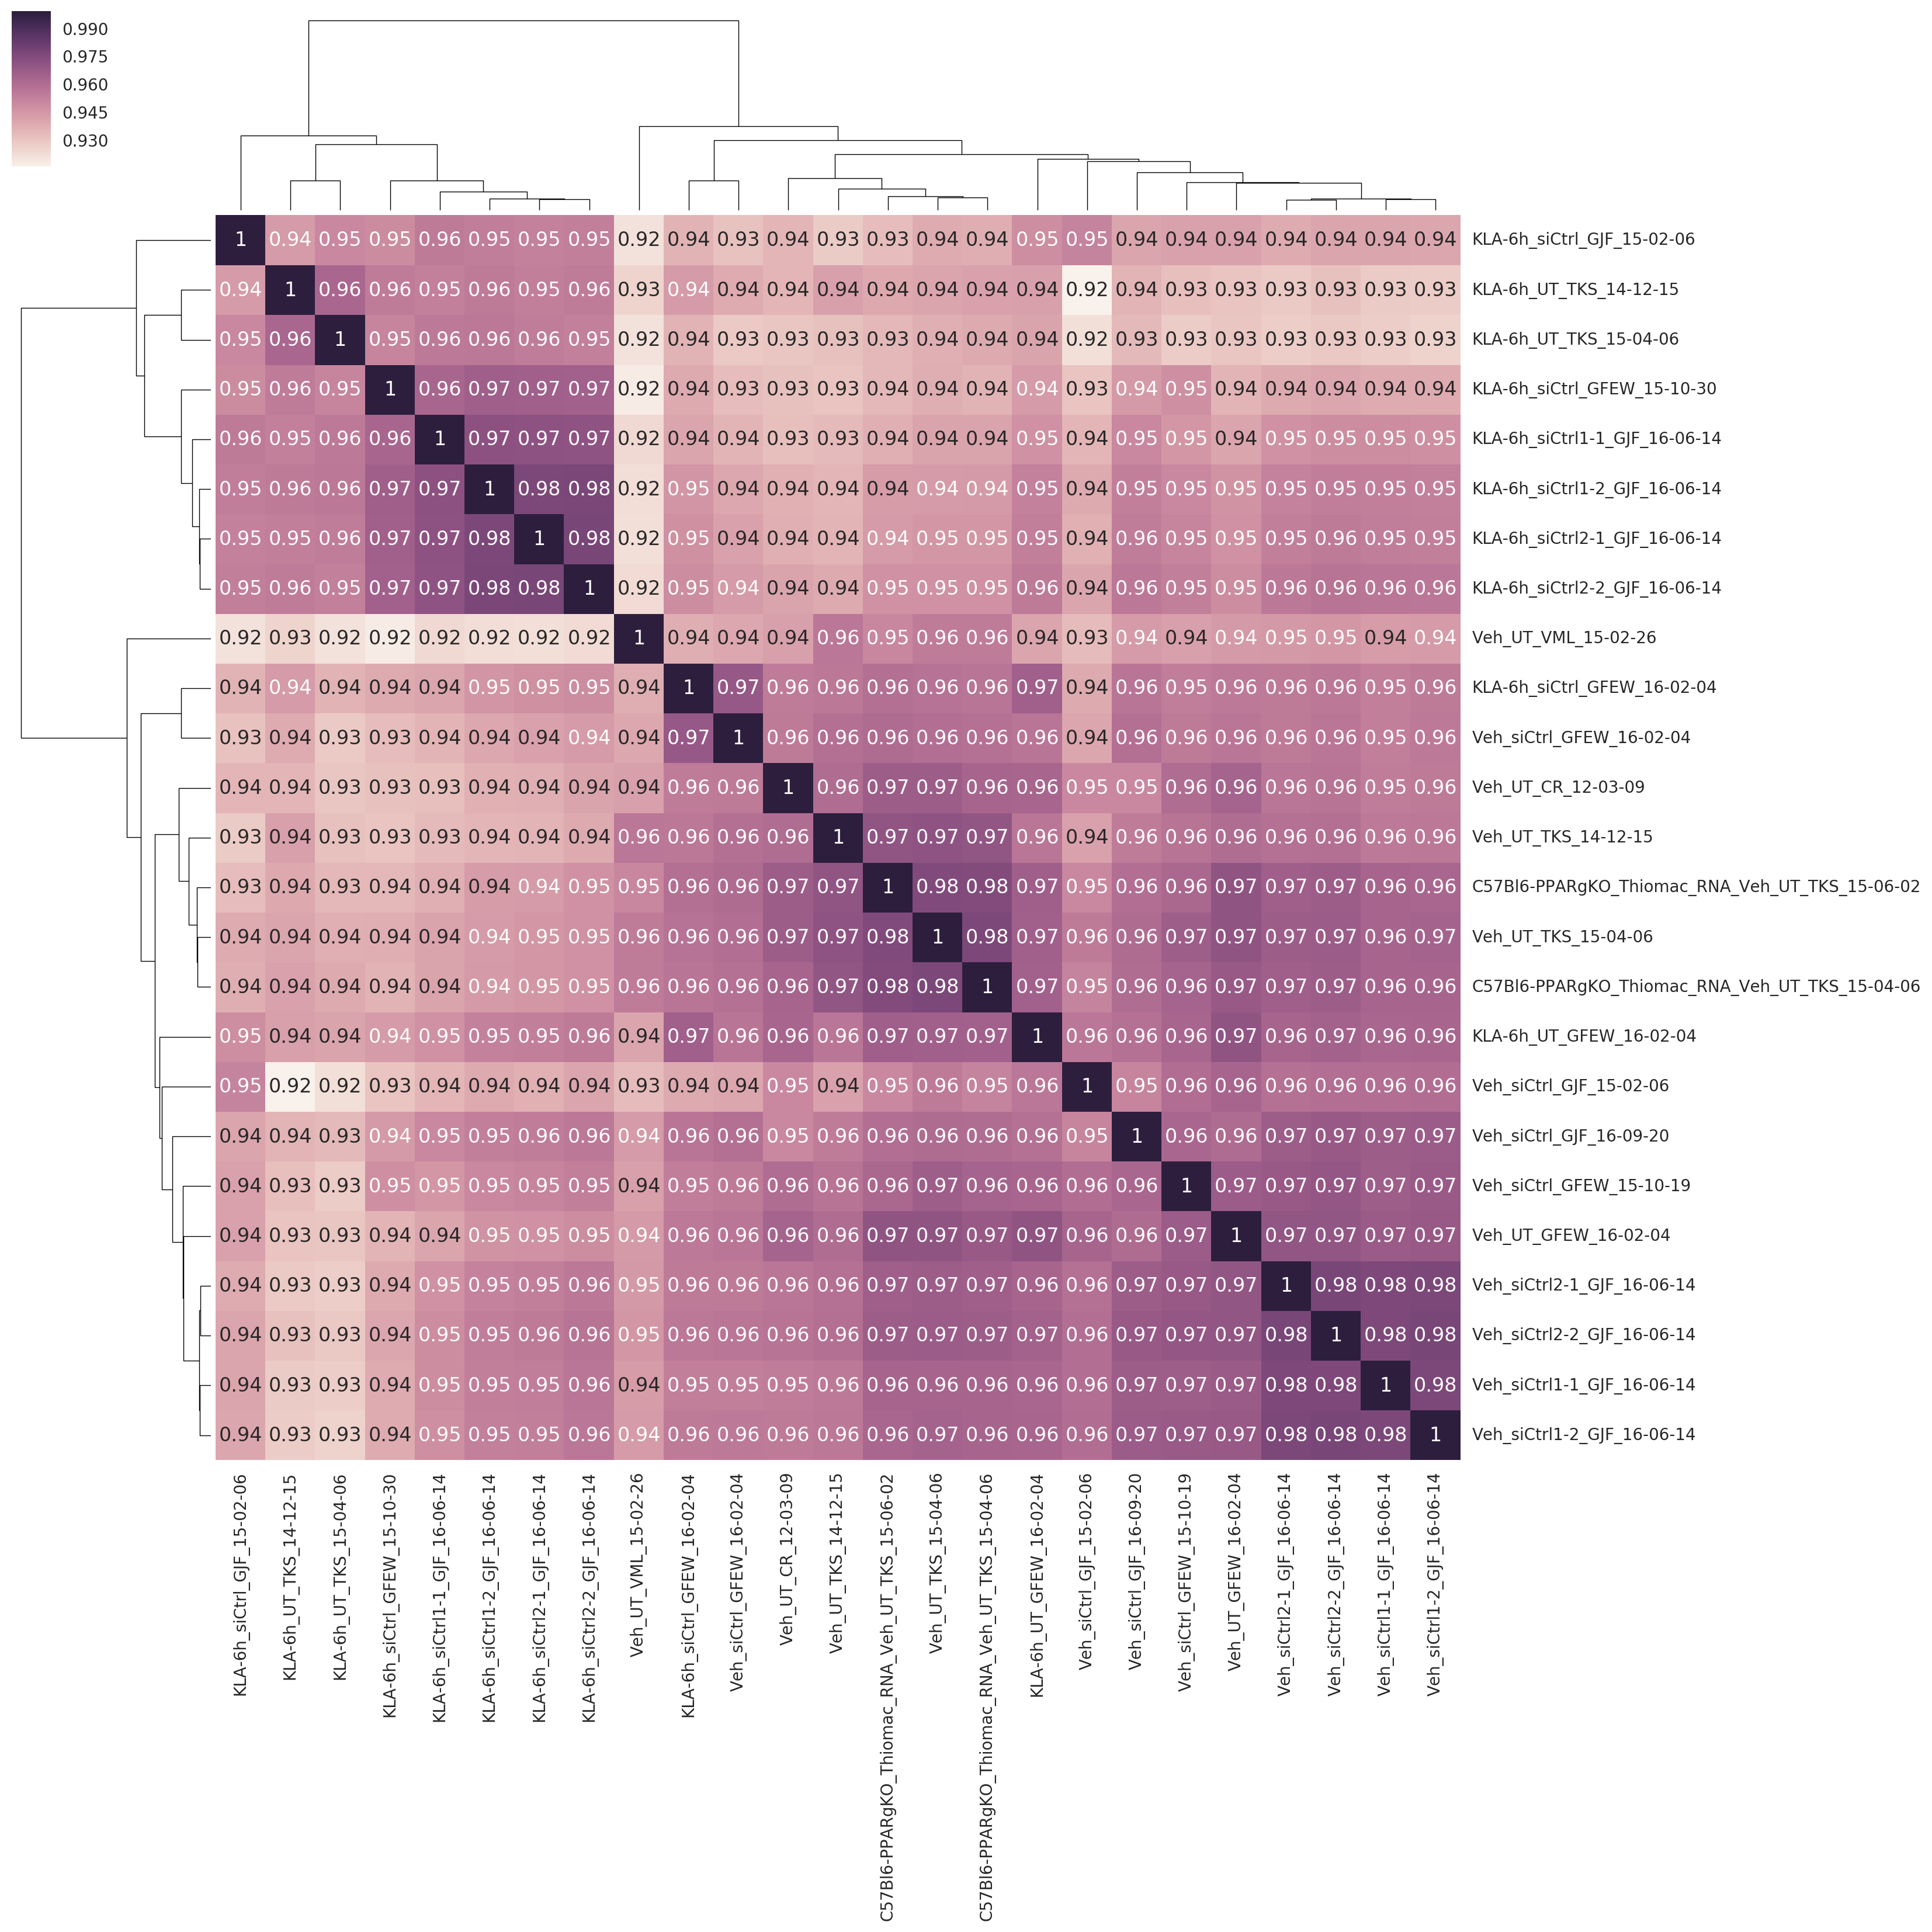

In [176]:
calcSpearmanCorrelation(raw_frame, 
                [x for x in raw_frame.columns[9:].values if ('Ctrl' in x or 'UT' in x) and not '-1h' in x], 
                True)

#### Vehicle

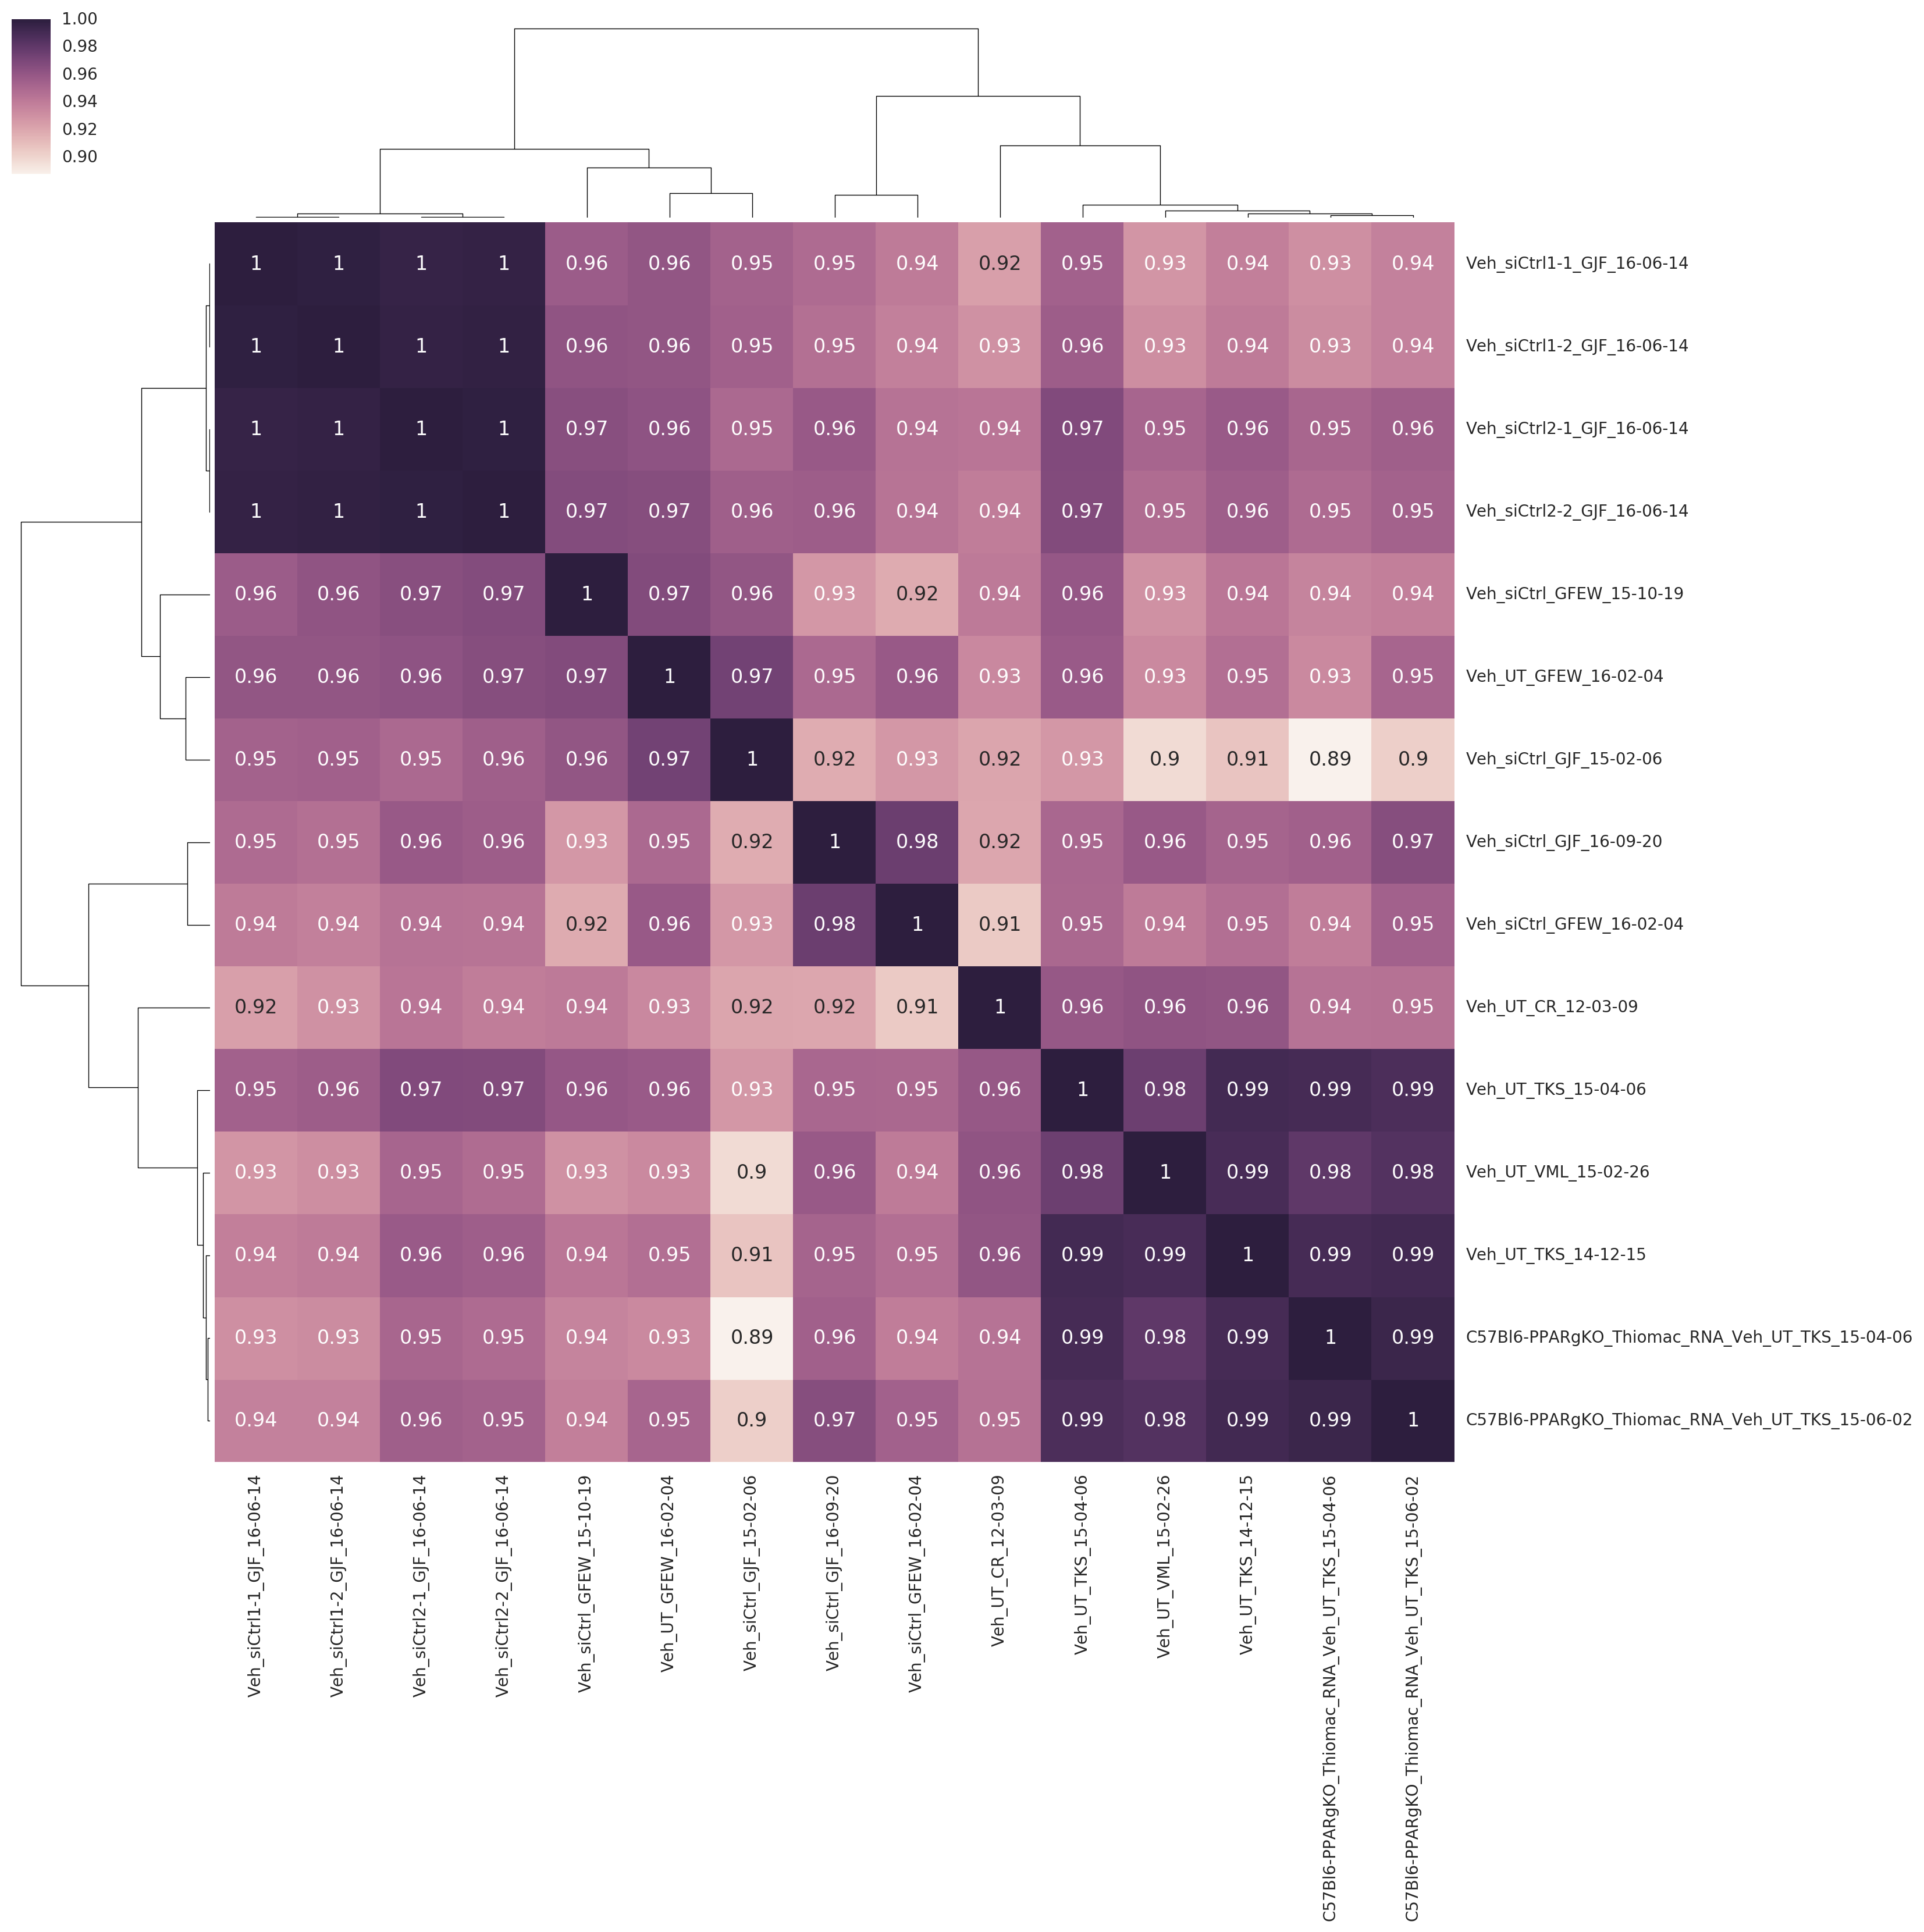

In [177]:
calcCorrelation(raw_frame, 
                [x for x in raw_frame.columns[9:].values if ('Ctrl' in x or 'UT' in x) and (not '-1h' in x and 'Veh' in x)], 
                True)

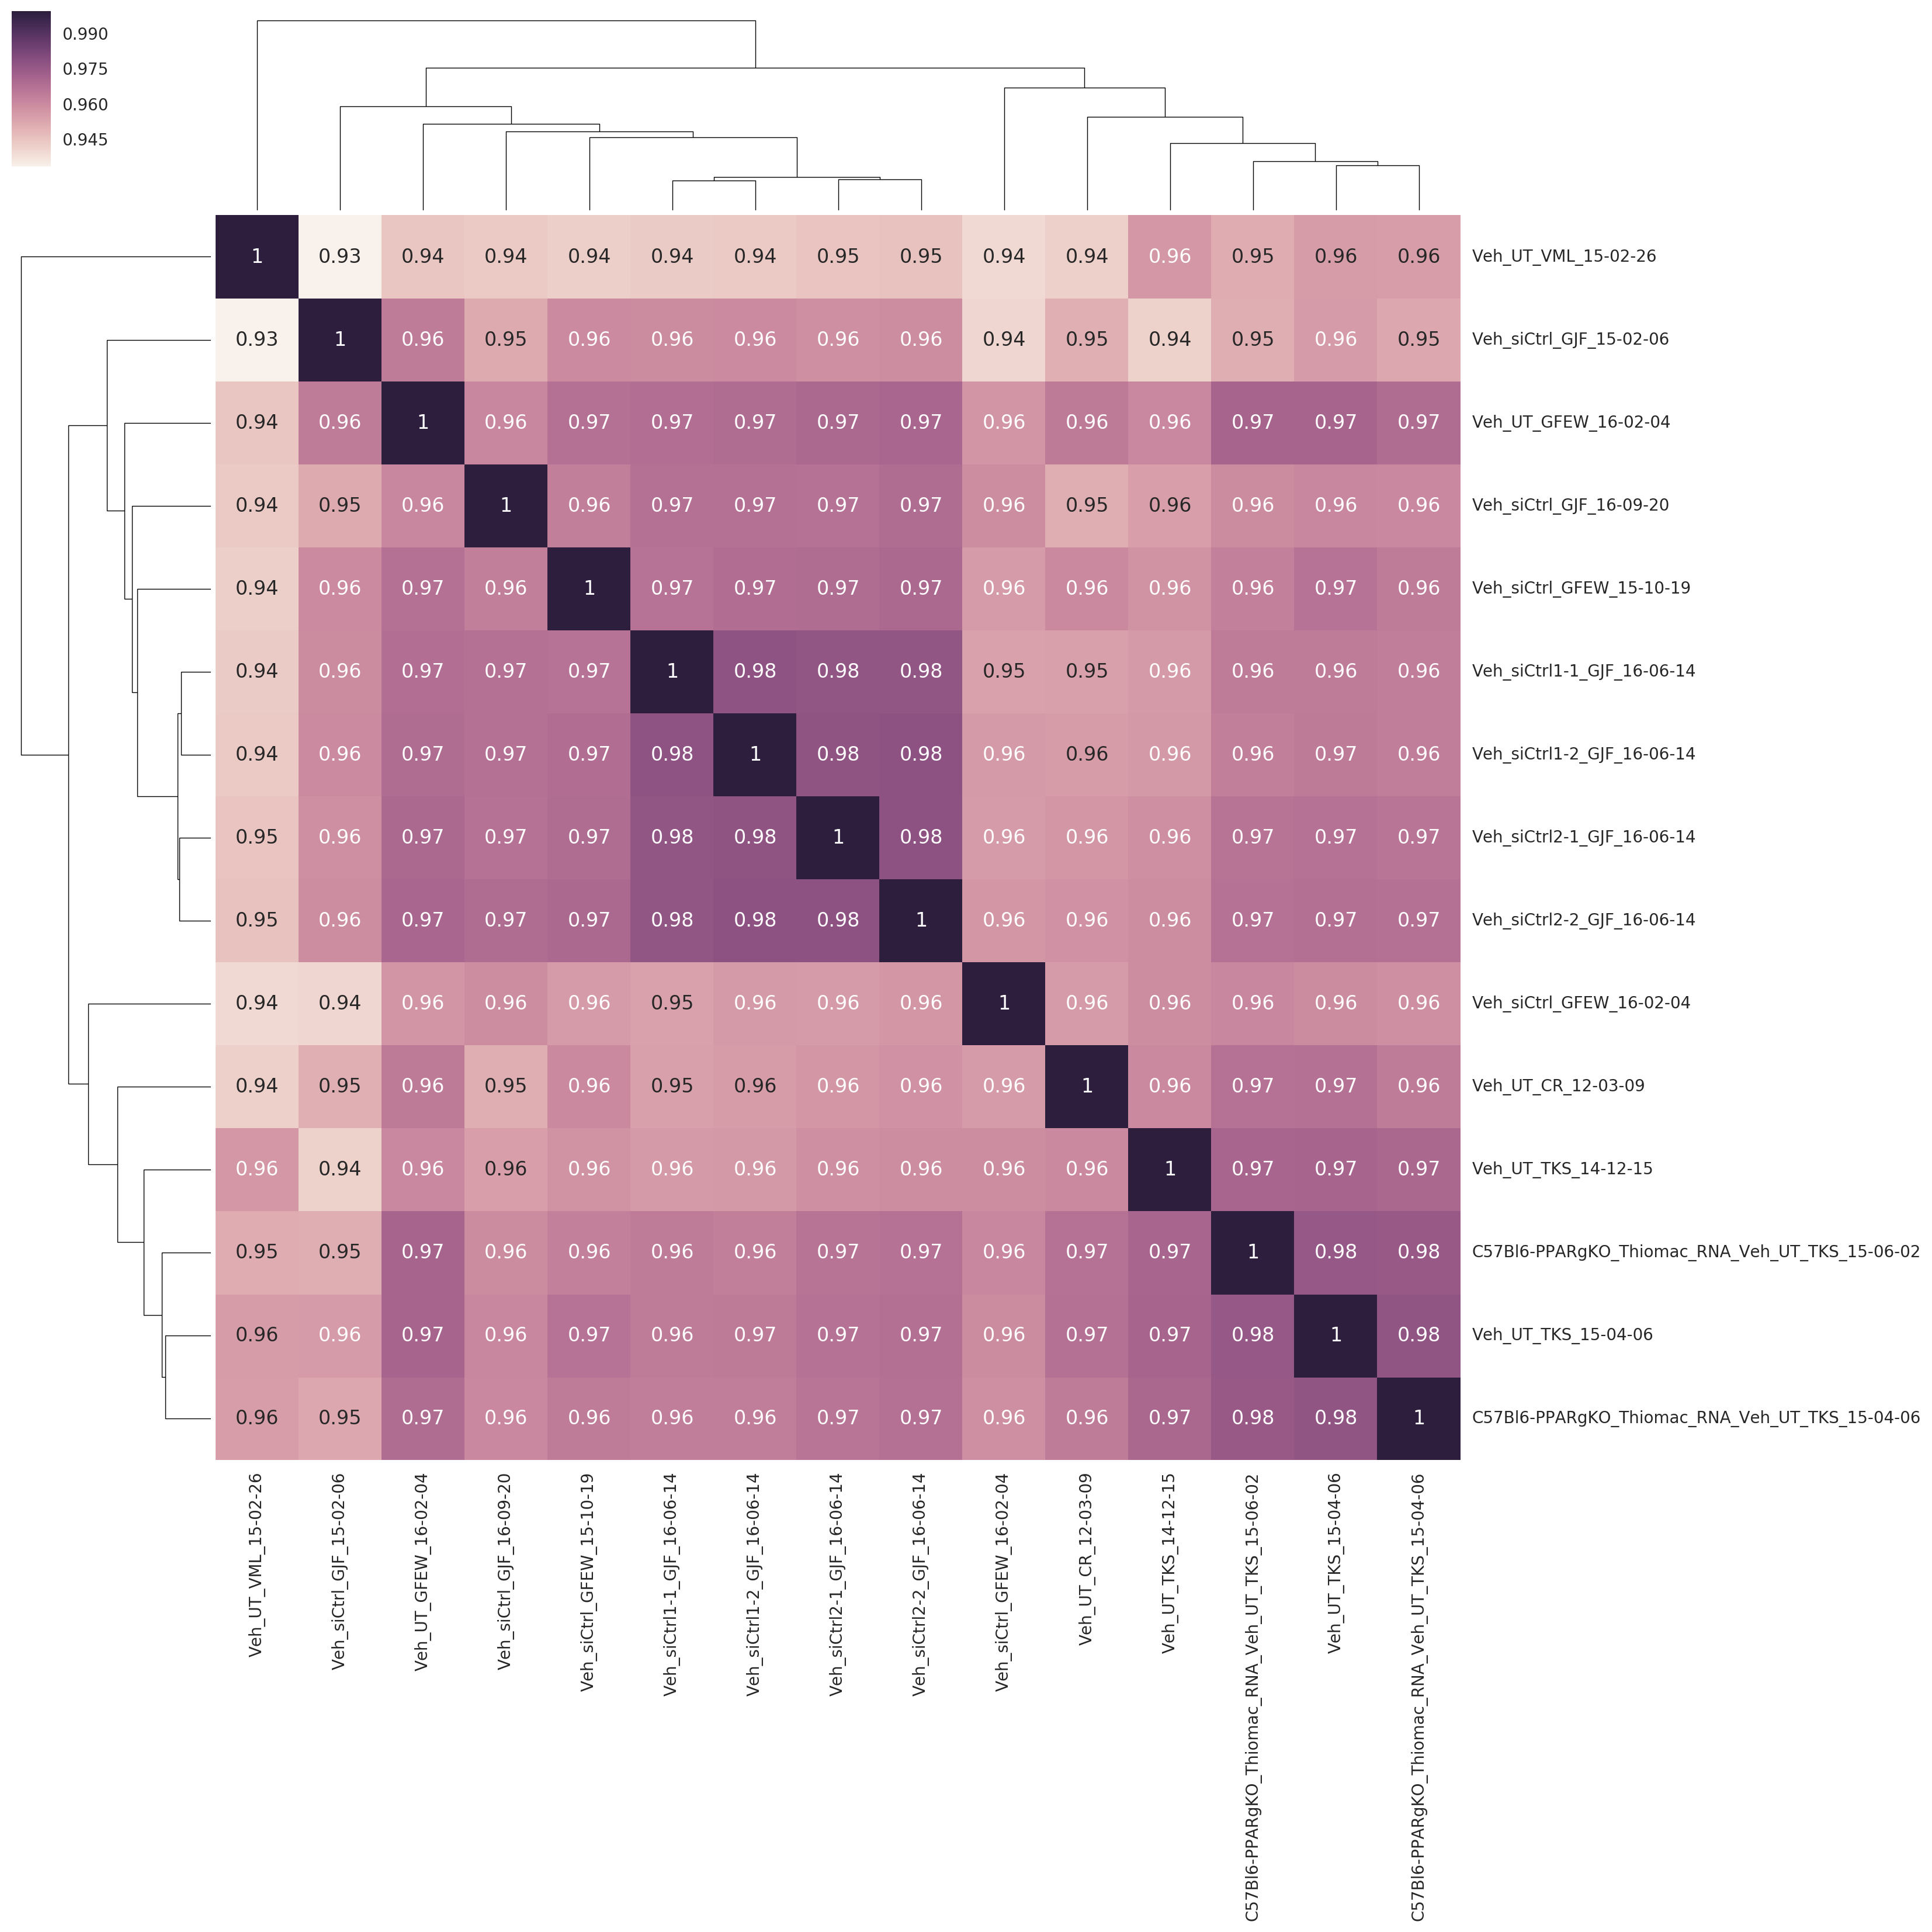

In [178]:
calcSpearmanCorrelation(raw_frame, 
                [x for x in raw_frame.columns[9:].values if ('Ctrl' in x or 'UT' in x) and (not '-1h' in x and 'Veh' in x)], 
                True)

#### KLA

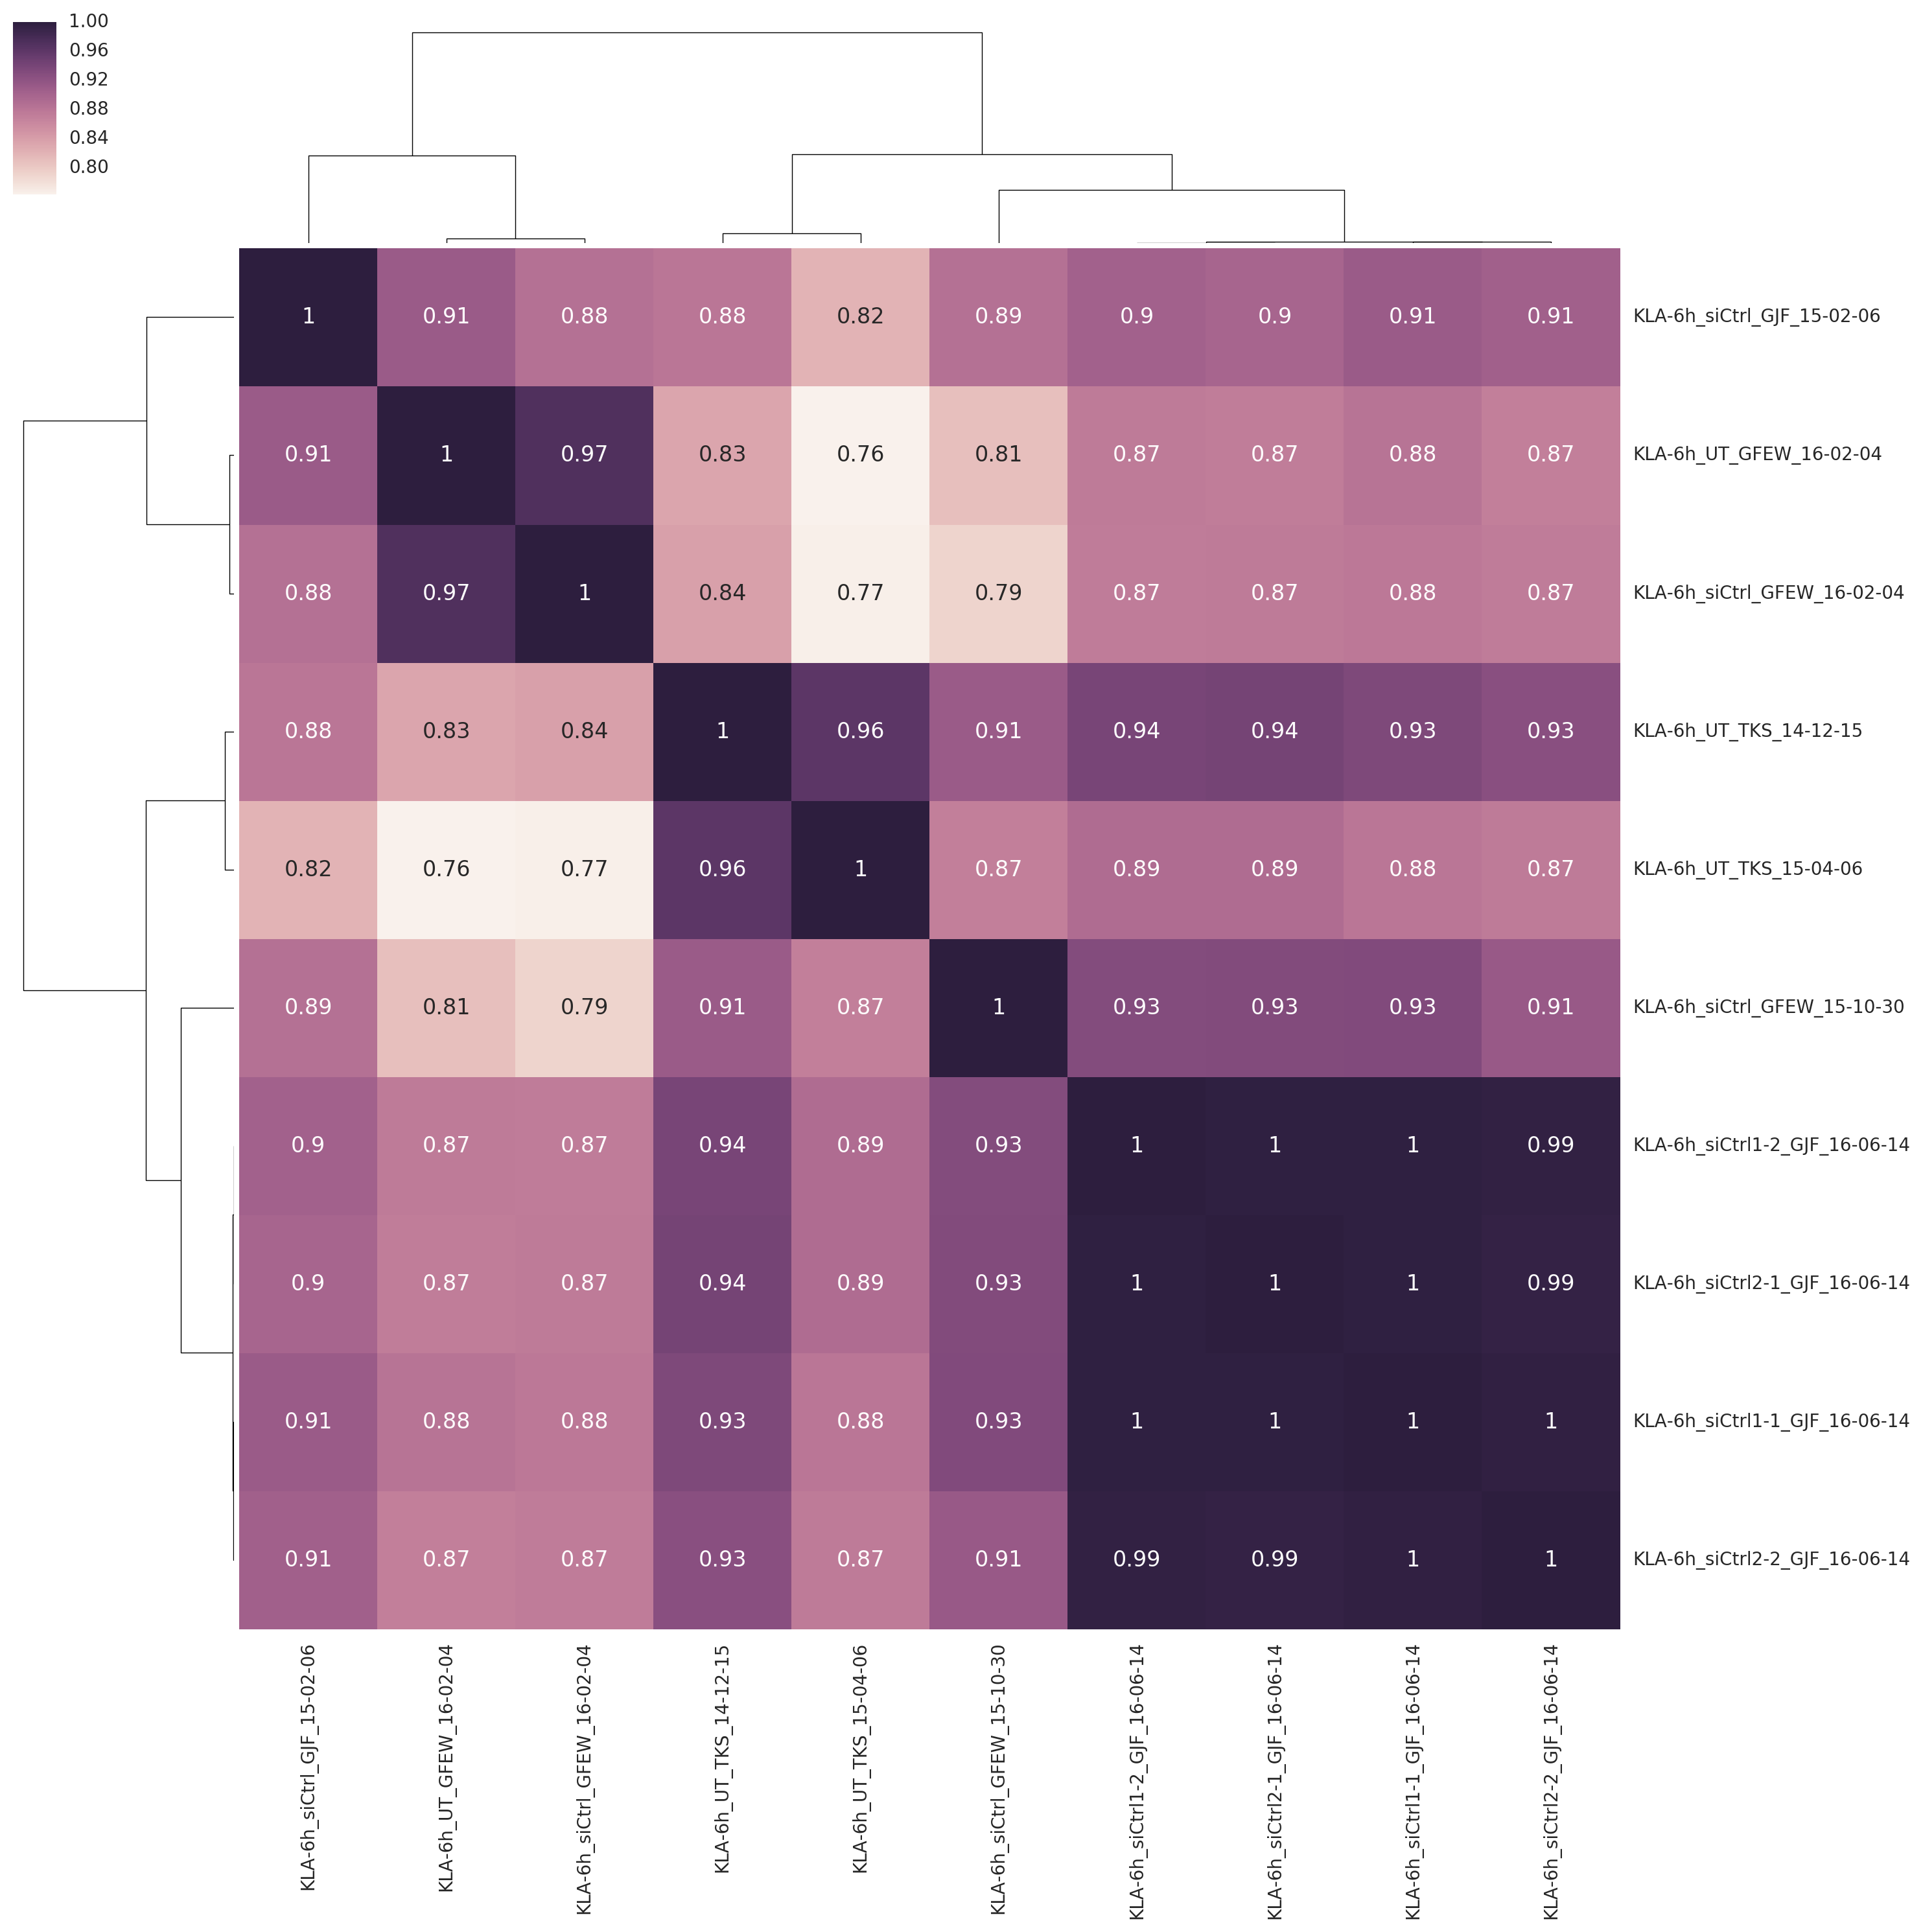

In [179]:
calcCorrelation(raw_frame, 
                [x for x in raw_frame.columns[9:].values if ('Ctrl' in x or 'UT' in x) and (not '-1h' in x and 'KLA' in x)], 
                True)

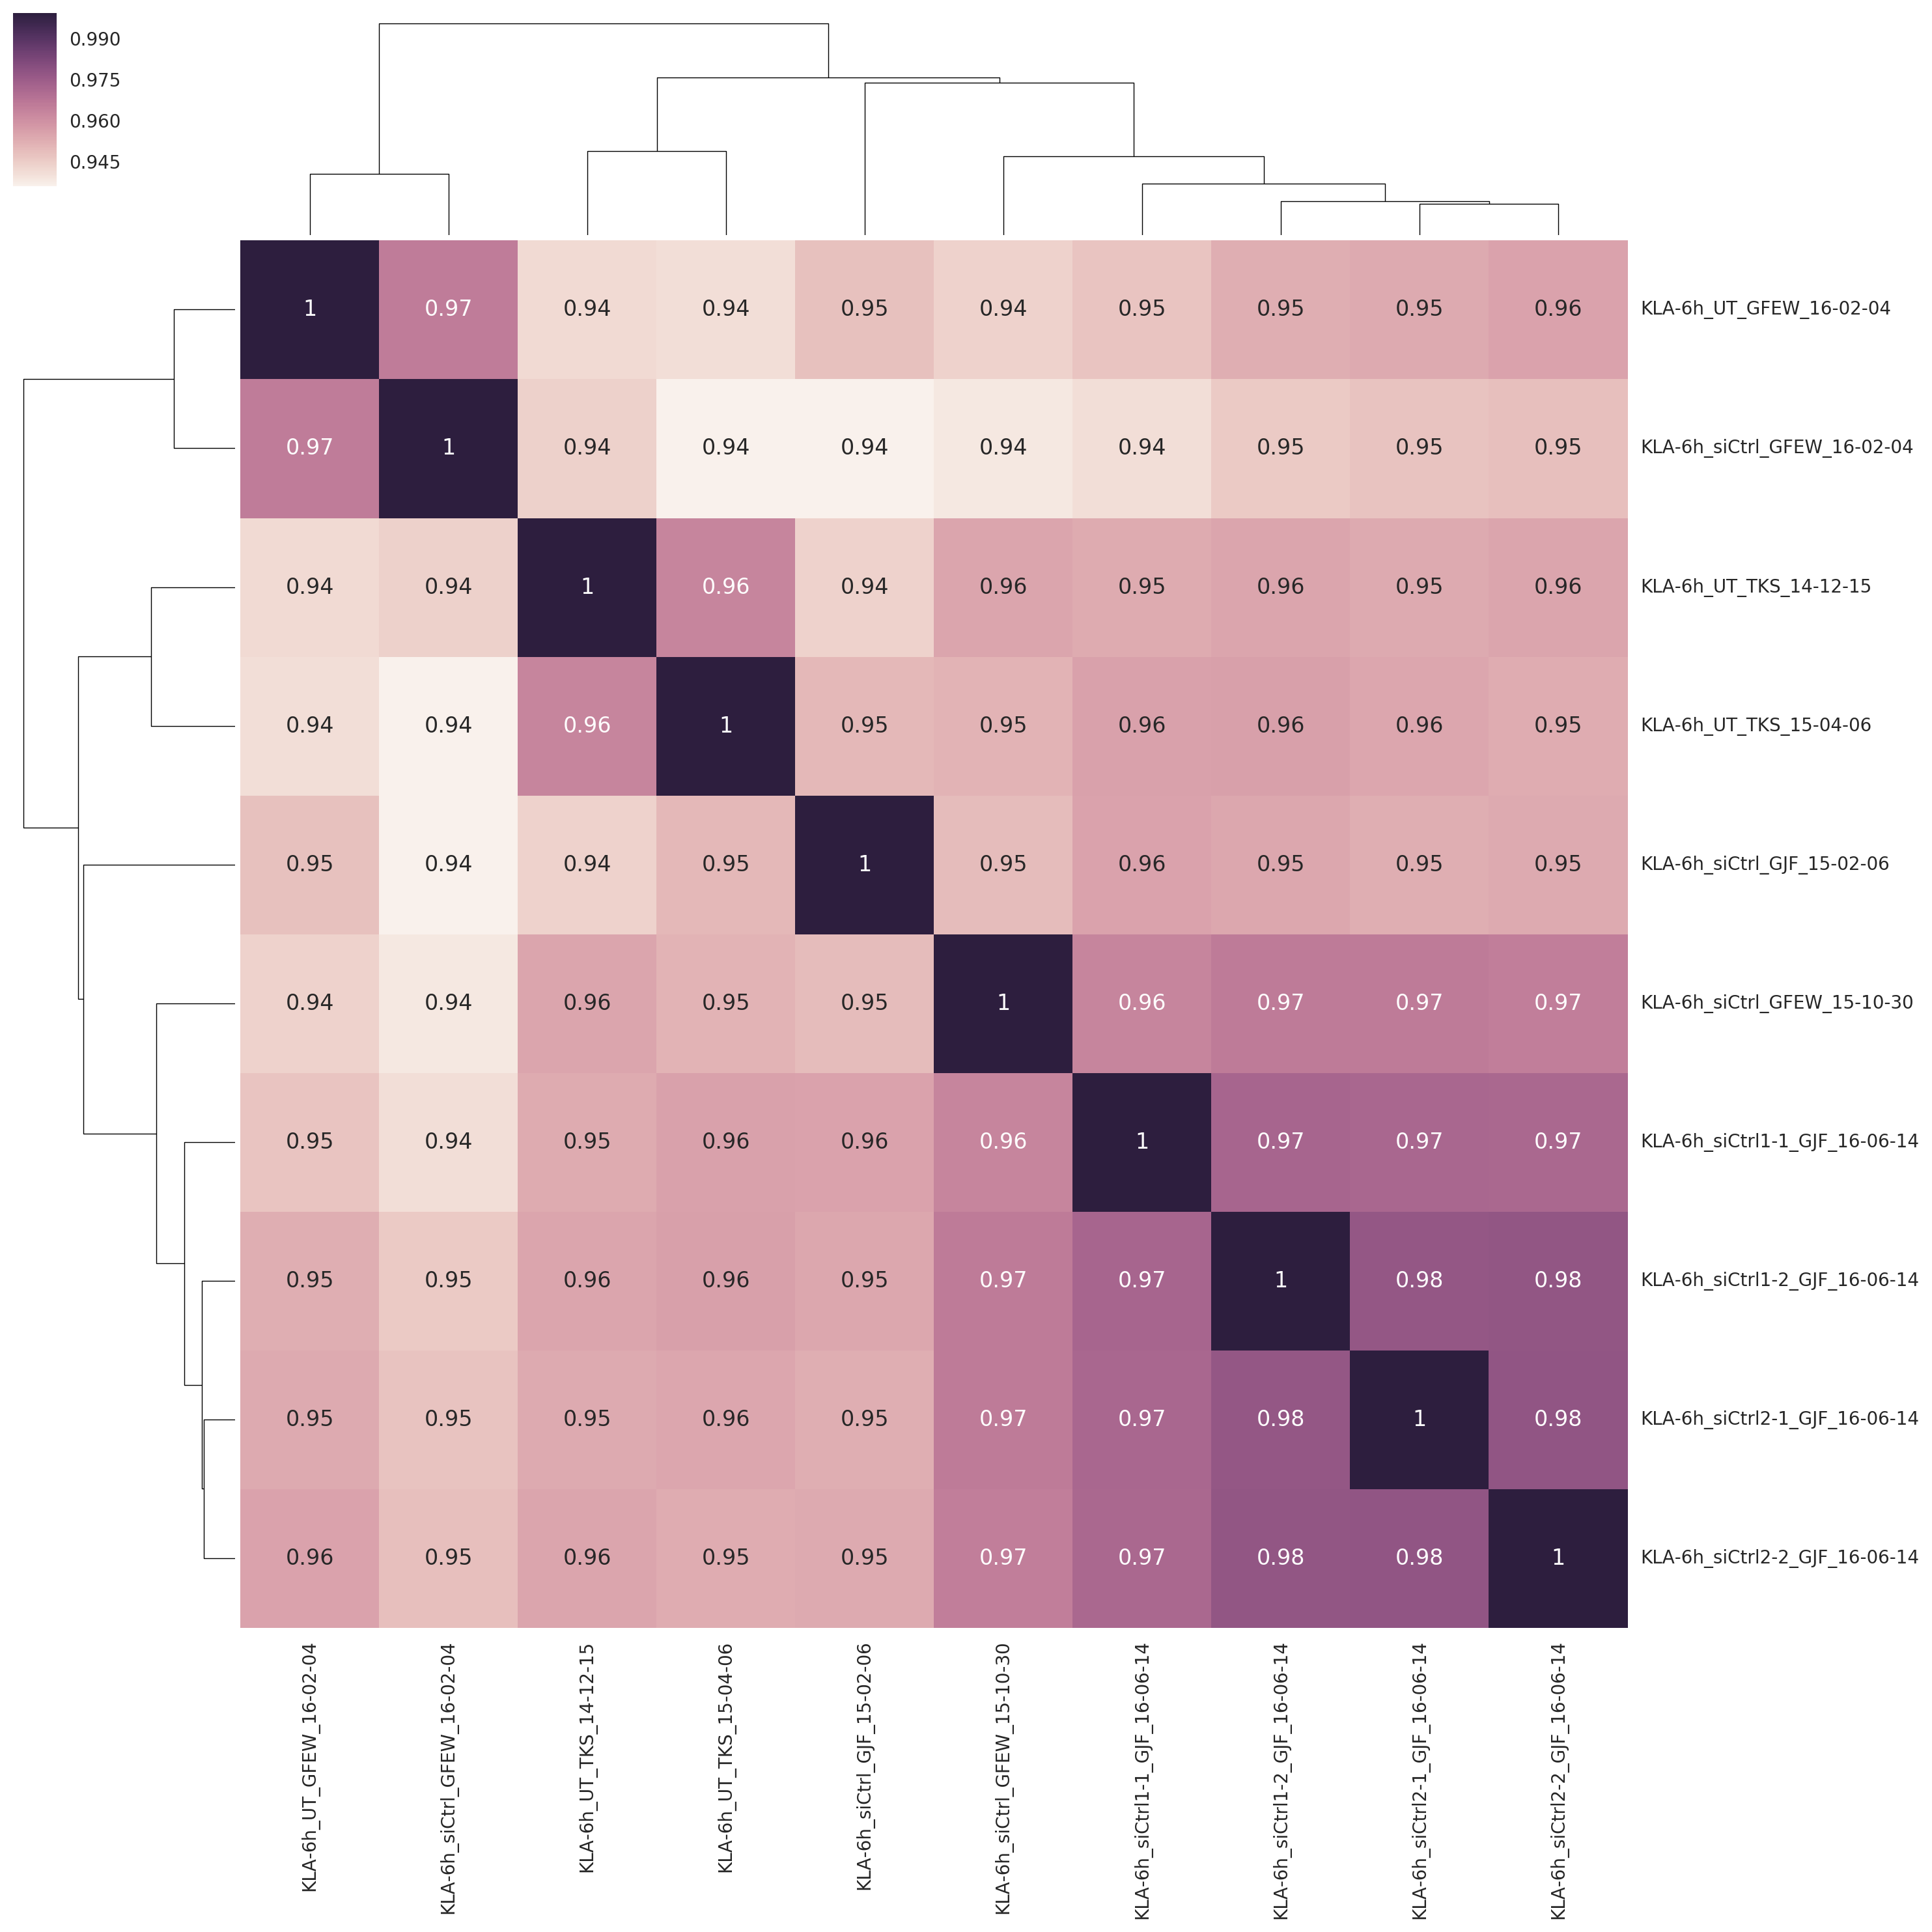

In [180]:
calcSpearmanCorrelation(raw_frame, 
                [x for x in raw_frame.columns[9:].values if ('Ctrl' in x or 'UT' in x) and (not '-1h' in x and 'KLA' in x)], 
                True)

## Differential Expression between Untreated and siCtrl

In [181]:
samples = raw_frame.columns[9:].values
samples = [x for x in samples if 'UT' in x or 'siCtrl' in x]
# samples = [x for x in samples if 'TKS' in x or '16-06-14' in x]
samples = [x for x in samples if 'TKS' in x or 'siCtrl1' in x]
samples = [x for x in samples if 'Veh' in x]

filteredTagDirectories = ' '.join(['/home/jtao/analysis/ap1_analysis/tag_directories_rna/' +x for x in samples])

!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d $filteredTagDirectories > raw_veh_control.tsv

conditions = ['_'.join(x.split('_')[3:5]) for x in samples]
conditions = [x[:-3] if 'Ctrl' in x else x for x in conditions]
conditions = ' '.join(conditions)
! getDiffExpression.pl raw_veh_control.tsv -AvsA $conditions > homer_diffExpresion_veh_control.tsv



	Tag Directories:
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_14-12-15
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_15-04-06
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_siCtrl1-1_GJF_16-06-14
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_siCtrl1-2_GJF_16-06-14
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6-PPARgKO_Thiomac_RNA_Veh_UT_TKS_15-04-06
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6-PPARgKO_Thiomac_RNA_Veh_UT_TKS_15-06-02
	Input file format: homerRmsk
	Filtering based on repeat parameters: kept 35756 of 35756
	Calculating read coverage for /home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_14-12-15
	Calculating read coverage for /home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_15-04-06
	Calculating read coverage for /home/jtao/analysis/ap

In [182]:
samples = raw_frame.columns[9:].values
samples = [x for x in samples if 'UT' in x or 'siCtrl' in x]
# samples = [x for x in samples if 'TKS' in x or '16-06-14' in x]
samples = [x for x in samples if 'TKS' in x or 'siCtrl1' in x]
samples = [x for x in samples if 'KLA' in x]

filteredTagDirectories = ' '.join(['/home/jtao/analysis/ap1_analysis/tag_directories_rna/' +x for x in samples])

!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d $filteredTagDirectories > raw_kla_control.tsv

conditions = ['_'.join(x.split('_')[3:5]) for x in samples]
conditions = [x[:-3] if 'Ctrl' in x else x for x in conditions]
conditions = ' '.join(conditions)
! getDiffExpression.pl raw_kla_control.tsv -AvsA $conditions > homer_diffExpresion_kla_control.tsv




	Tag Directories:
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_14-12-15
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_15-04-06
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_siCtrl1-1_GJF_16-06-14
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_siCtrl1-2_GJF_16-06-14
	Input file format: homerRmsk
	Filtering based on repeat parameters: kept 35756 of 35756
	Calculating read coverage for /home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_14-12-15
	Calculating read coverage for /home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_15-04-06
	Calculating read coverage for /home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_siCtrl1-1_GJF_16-06-14
	Calculating read coverage for /home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA

In [183]:
samples = raw_frame.columns[9:].values
samples = [x for x in samples if 'UT' in x or 'siCtrl' in x]
# samples = [x for x in samples if 'TKS' in x or '16-06-14' in x]
samples = [x for x in samples if 'TKS' in x or 'siCtrl1' in x]

filteredTagDirectories = ' '.join(['/home/jtao/analysis/ap1_analysis/tag_directories_rna/' +x for x in samples])

!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d $filteredTagDirectories > raw_control.tsv


conditions = ['_'.join(x.split('_')[3:5]) for x in samples]
conditions = [x[:-3] if 'Ctrl' in x else x for x in conditions]
conditions = ' '.join(conditions)
!getDiffExpression.pl raw_control.tsv -AvsA $conditions > homer_diffExpresion_control.tsv

	Tag Directories:
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_14-12-15
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_15-04-06
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_14-12-15
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_15-04-06
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_siCtrl1-1_GJF_16-06-14
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_siCtrl1-1_GJF_16-06-14
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_siCtrl1-2_GJF_16-06-14
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_siCtrl1-2_GJF_16-06-14
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6-PPARgKO_Thiomac_RNA_Veh_UT_TKS_15-04-06
		/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6-PPARgKO_Thiomac_RNA_Veh_UT

In [184]:
control_raw_frame = pd.read_csv("raw_control.tsv",sep="\t")

columns = control_raw_frame.columns.values

columns = [columns[0]] + [x.strip().split('/')[-1].split()[0] if 'tag_directories' in x else x for x in columns[1:]]
columns = [x.replace('C57Bl6_Thiomac_RNA_','') for x in columns]
control_raw_frame.columns = columns
control_raw_frame.index = [x.split('|')[0].upper() for x in control_raw_frame['Annotation/Divergence'].values]
control_raw_frame = control_raw_frame.ix[:,8:]

In [185]:
control_diff_veh_frame = pd.read_csv('homer_diffExpresion_veh_control.tsv', sep='\t')
columns = control_diff_veh_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
control_diff_veh_frame.columns=columns
control_diff_veh_frame['gene'] = [x.split('|')[0].upper() for x in control_diff_veh_frame['Divergence']]
control_diff_veh_frame.index = control_diff_veh_frame.gene.values
columns = ['refseq', 'gene'] + [x for x in control_diff_veh_frame.columns if 'vs.' in x]
control_diff_veh_frame = control_diff_veh_frame[columns]

In [186]:
control_diff_kla_frame = pd.read_csv('homer_diffExpresion_kla_control.tsv', sep='\t')
columns = control_diff_kla_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
control_diff_kla_frame.columns=columns
control_diff_kla_frame['gene'] = [x.split('|')[0].upper() for x in control_diff_kla_frame['Divergence']]
control_diff_kla_frame.index = control_diff_kla_frame.gene.values
columns = ['refseq', 'gene'] + [x for x in control_diff_kla_frame.columns if 'vs.' in x]
control_diff_kla_frame = control_diff_kla_frame[columns]

In [187]:
control_diff_frame = pd.read_csv('homer_diffExpresion_control.tsv', sep='\t')
columns = control_diff_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
control_diff_frame.columns=columns
control_diff_frame['gene'] = [x.split('|')[0].upper() for x in control_diff_frame['Divergence']]
control_diff_frame.index = control_diff_frame.gene.values
columns = ['refseq', 'gene'] + [x for x in control_diff_frame.columns if 'vs.' in x]
control_diff_frame = control_diff_frame[columns]

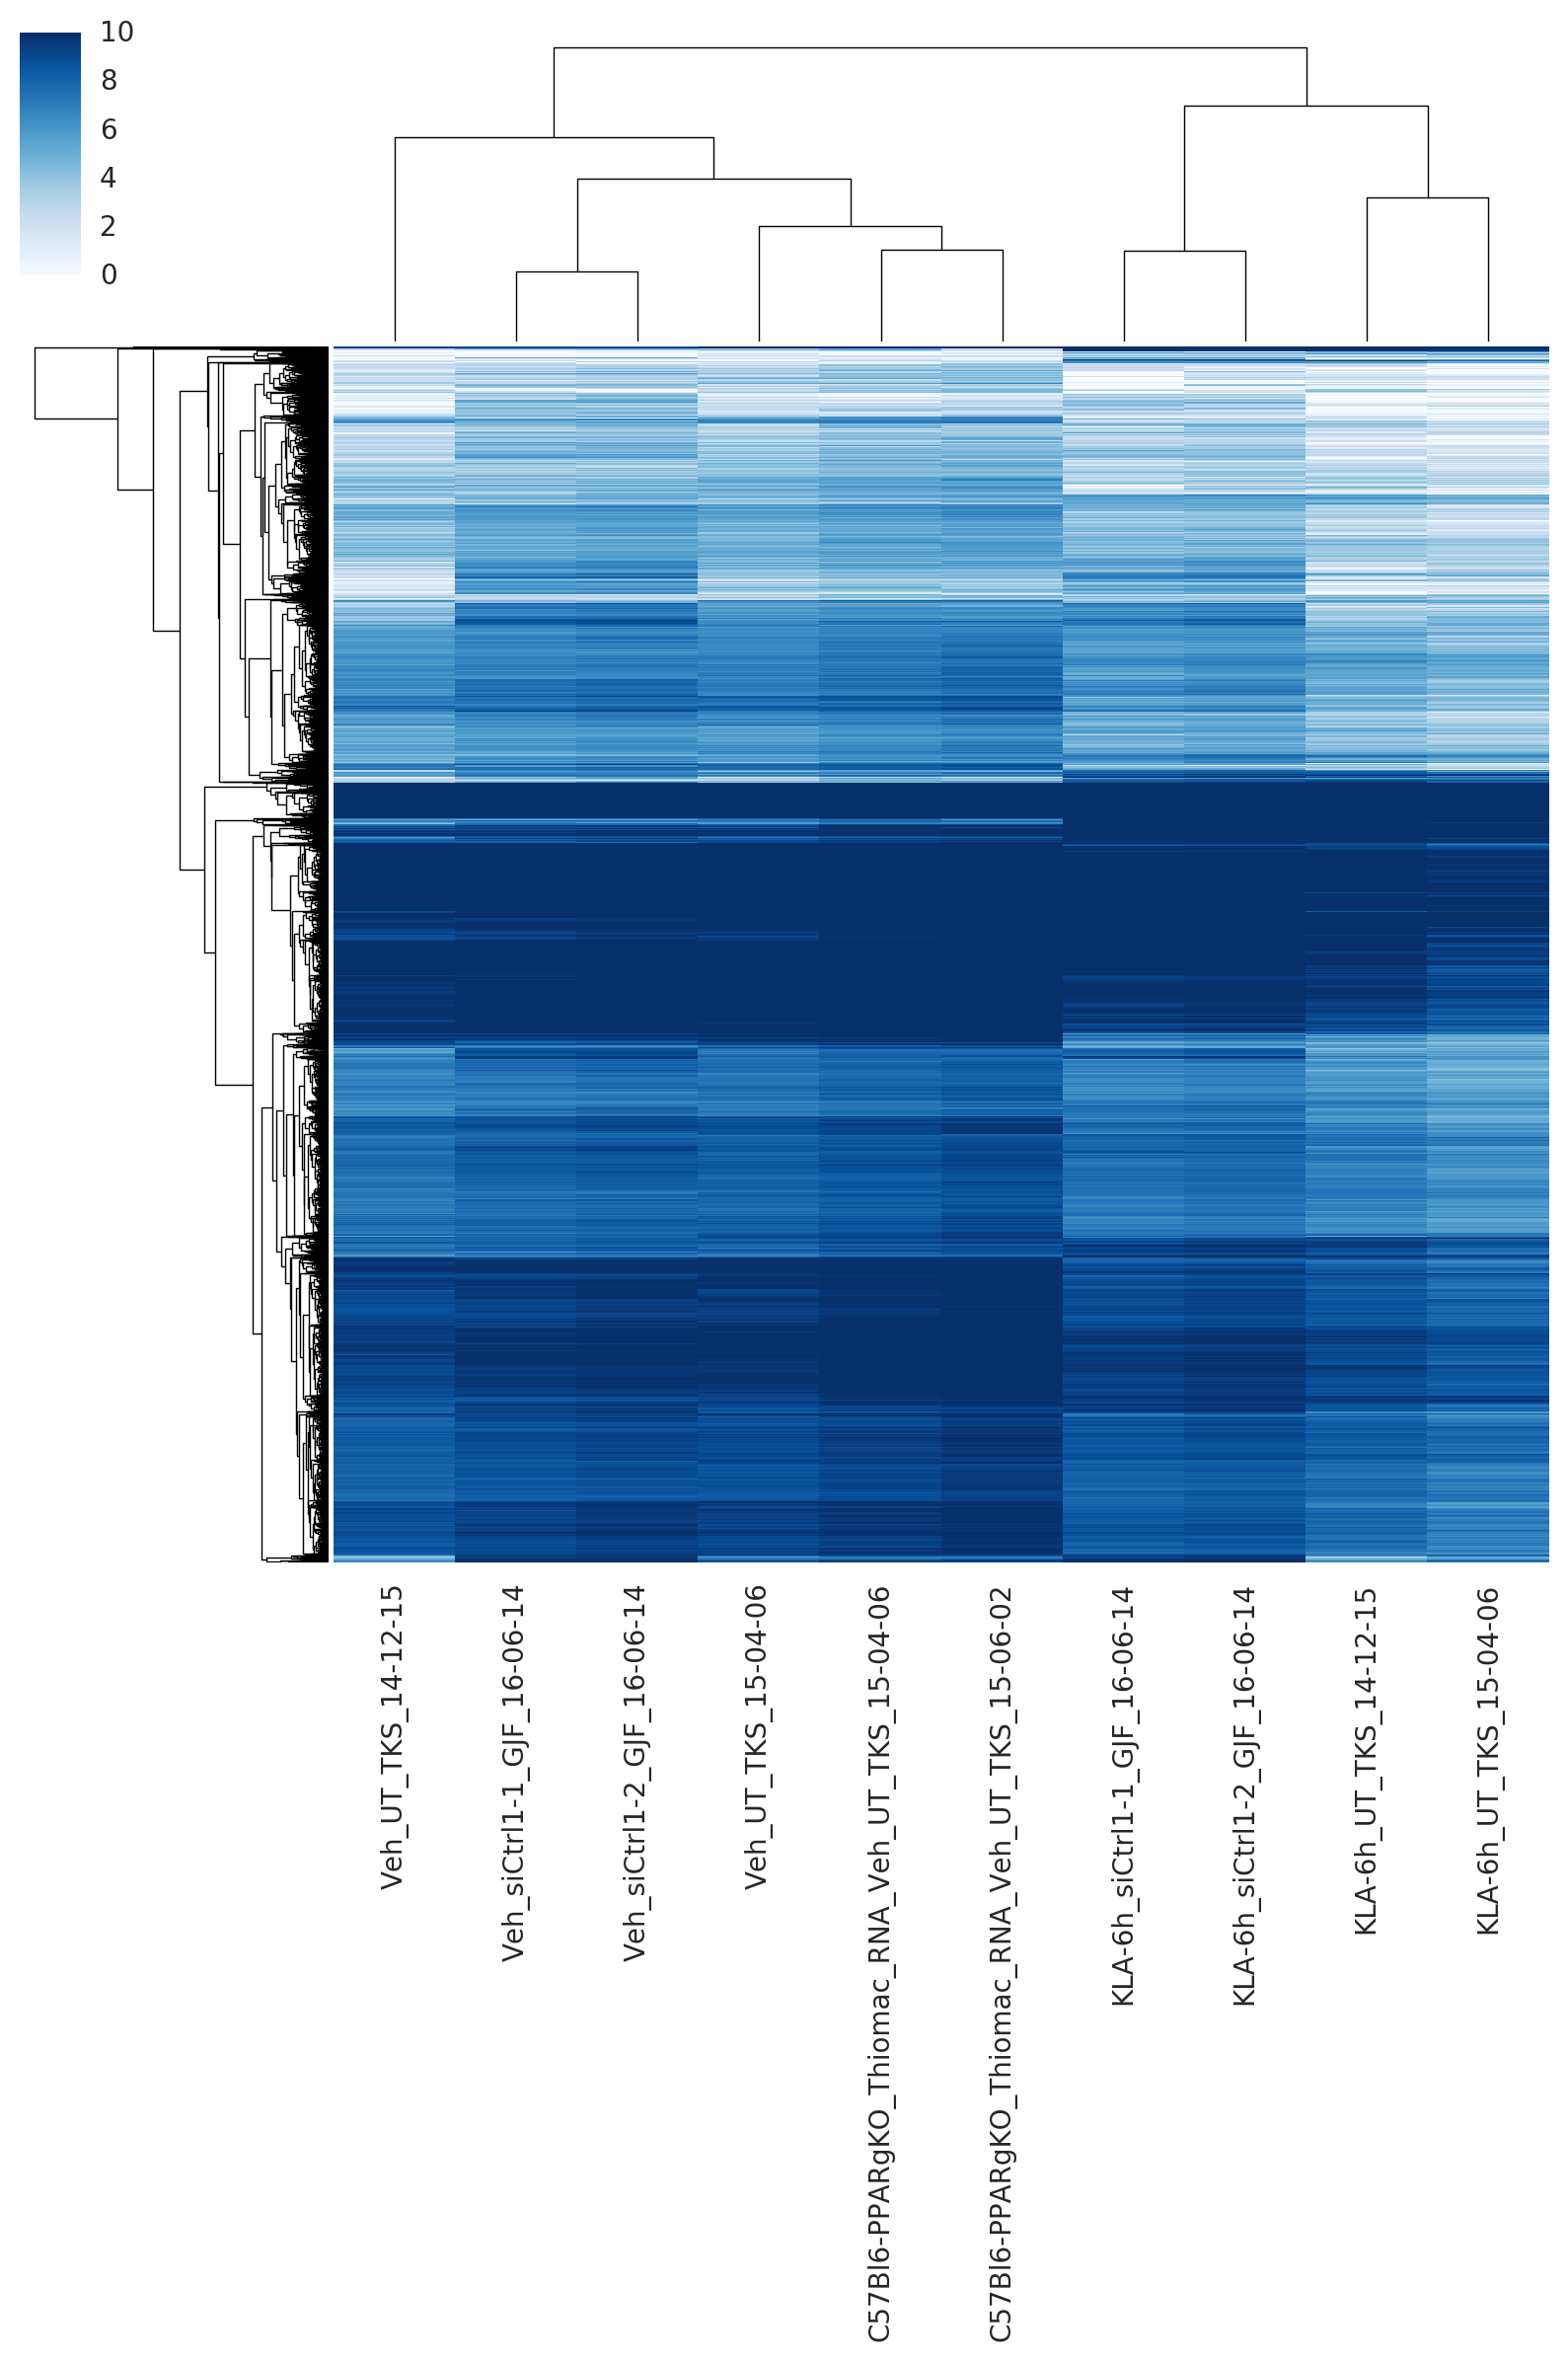

In [188]:
sns.clustermap(np.log2(control_raw_frame[(control_raw_frame.max(axis=1) > 16)]+1),
               vmax = 10,
               cmap='Blues',
               yticklabels=False)

In [189]:
p_threshold = 0.05
fold_threshold = 1
siCtrl_veh_genes = set(control_diff_veh_frame[(control_diff_veh_frame['Veh_UT vs. Veh_siCtrl adj. p-value'] < p_threshold) &
                                       (control_diff_veh_frame['Veh_UT vs. Veh_siCtrl Log2 Fold Change'].abs() > fold_threshold)]['gene'].values)

siCtrl_kla_genes = set(control_diff_kla_frame[(control_diff_kla_frame['KLA-6h_UT vs. KLA-6h_siCtrl adj. p-value'] < p_threshold) &
                                       (control_diff_kla_frame['KLA-6h_UT vs. KLA-6h_siCtrl Log2 Fold Change'].abs() > fold_threshold)]['gene'].values)

response_genes = set(control_diff_frame[(control_diff_frame['KLA-6h_UT vs. Veh_UT adj. p-value'] < p_threshold) &
                                       (control_diff_frame['KLA-6h_UT vs. Veh_UT Log2 Fold Change'].abs() > fold_threshold)]['gene'].values)

response_genes_ctrl = set(control_diff_frame[(control_diff_frame['KLA-6h_siCtrl vs. Veh_siCtrl adj. p-value'] < p_threshold) &
                                             (control_diff_frame['KLA-6h_siCtrl vs. Veh_siCtrl Log2 Fold Change'].abs() > fold_threshold)]['gene'].values)



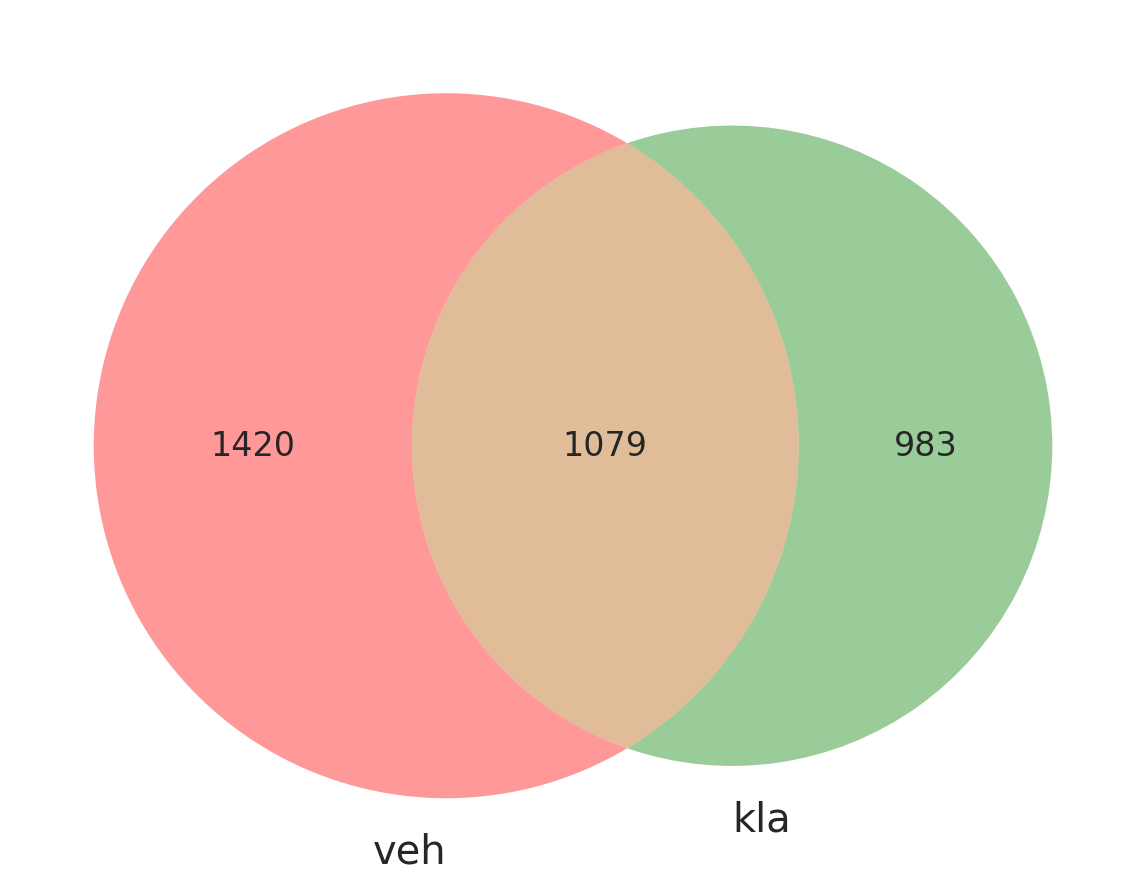

In [190]:
venn2([siCtrl_veh_genes,siCtrl_kla_genes], ['veh', 'kla'])

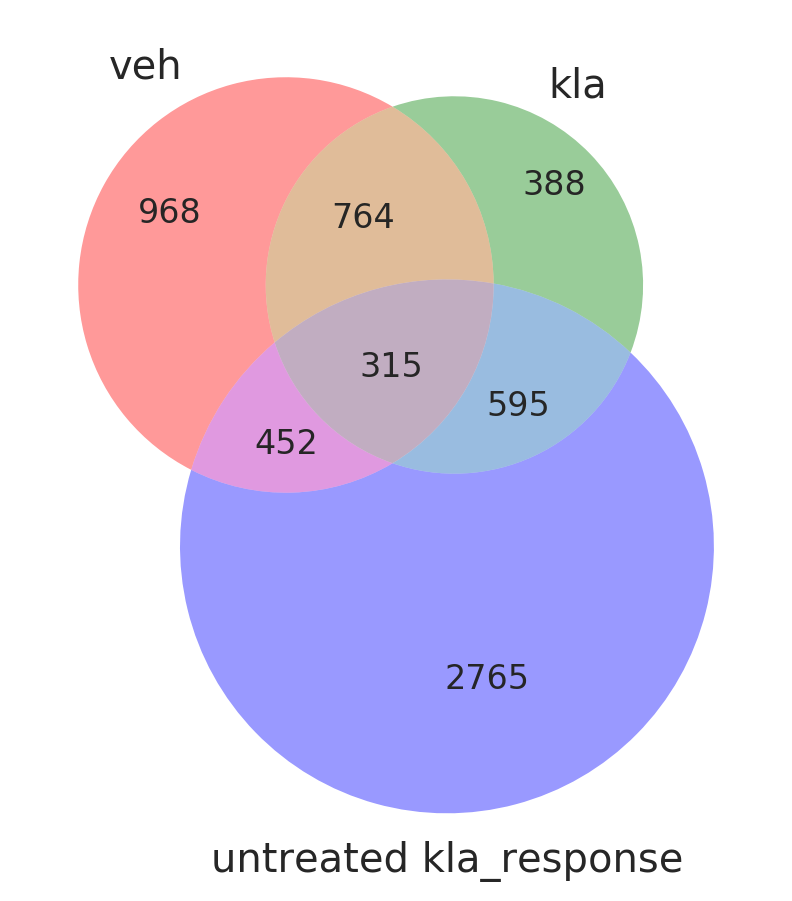

In [191]:
venn3([siCtrl_veh_genes,siCtrl_kla_genes, response_genes], ['veh', 'kla', 'untreated kla_response'])

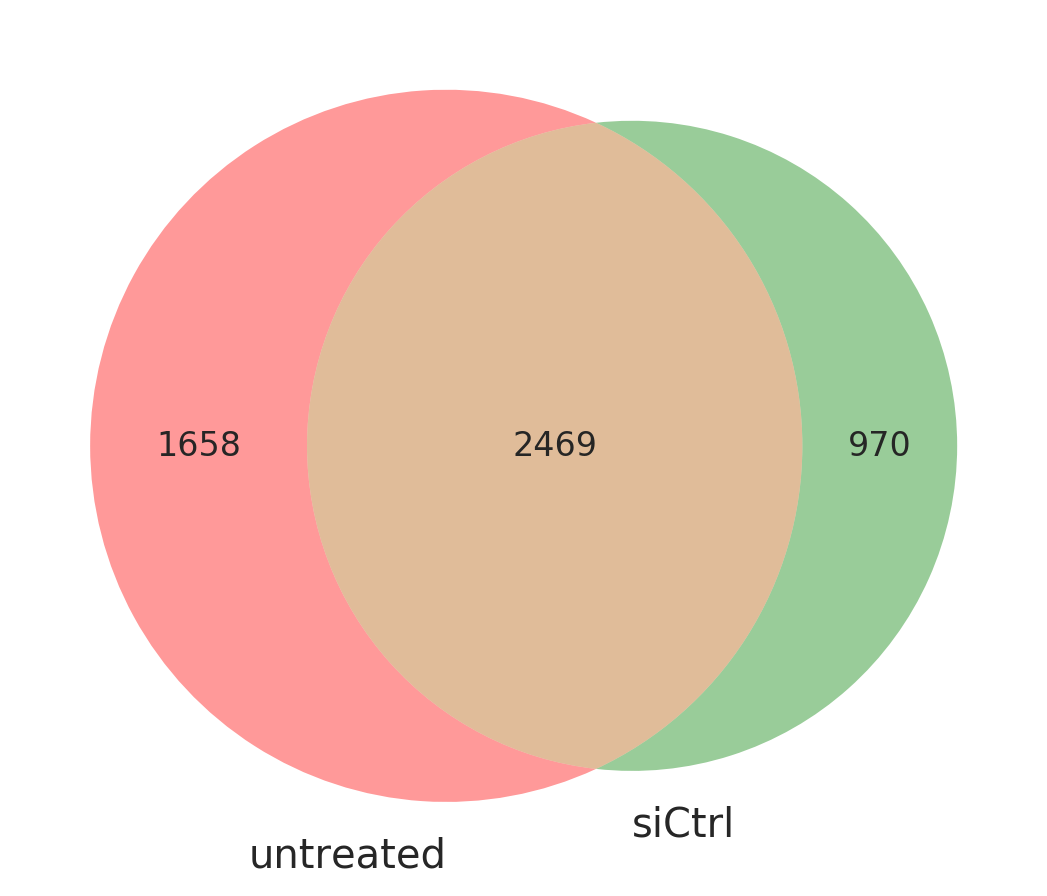

In [192]:
venn2([response_genes, response_genes_ctrl], ['untreated', 'siCtrl'])

## Calcuate Differential Expression with EdgeR

In [193]:
sample_condition_dict = dict(zip(filtered_summary_frame_rna['sampleName'], 
                                 filtered_summary_frame_rna['target']
                                 + '_'+ filtered_summary_frame_rna['treatment']))

In [194]:
factor_gene_dict = {'atf3':'ATF3',
                    'cjun':'JUN',
                    'fos':'FOS',
                    'junb':'JUNB',
                    'jund':'JUND'}

In [195]:
# pick replicates to use
# visualize expression of knockdown target
factors = []
treatments = []
rpkms = []

targets = [x for x in sorted(set(filtered_summary_frame_rna['target'])) if not 'UT' in x and not 'Ctrl' in x]
control_veh_samples = filtered_summary_frame_rna[filtered_summary_frame_rna['target'].str.contains('Ctrl1') &
                                                 (filtered_summary_frame_rna['treatment'] == 'Veh')]['sampleName'].values
control_kla_samples = filtered_summary_frame_rna[filtered_summary_frame_rna['target'].str.contains('Ctrl1') &
                                                 (filtered_summary_frame_rna['treatment'].str.contains('KLA'))]['sampleName'].values
untreated_veh_samples = filtered_summary_frame_rna[filtered_summary_frame_rna['target'].str.contains('UT') &
                                                 (filtered_summary_frame_rna['treatment'] == 'Veh') &
                                                 (filtered_summary_frame_rna['owner'] == 'TKS')]['sampleName'].values
untreated_kla_samples = filtered_summary_frame_rna[filtered_summary_frame_rna['target'].str.contains('UT') &
                                                 (filtered_summary_frame_rna['treatment'].str.contains('KLA')) &
                                                 (filtered_summary_frame_rna['owner'] == 'TKS')]['sampleName'].values
for treatment in ['Veh', 'KLA']:

    for target in targets:
        factor = target[2:].lower()
        if factor in factor_gene_dict:
            samples = filtered_summary_frame_rna[(filtered_summary_frame_rna['treatment'].str.contains(treatment)) &
                                                 (filtered_summary_frame_rna['target'] == target)]['sampleName'].values
    #         tagDirectories = ' '.join(['/home/jtao/analysis/ap1_analysis/tag_directories_rna/' +x for x in samples])
            if treatment == 'Veh':
                control_samples = control_veh_samples
                untreated_samples = untreated_veh_samples
            else:
                control_samples = control_kla_samples
                untreated_samples = untreated_kla_samples
            if len(samples) >= 2:
                # values for knockdown experiements
                current_frame = rpkm_frame[samples]
                current_rpkms = list(current_frame.ix[factor_gene_dict[factor]].values)
                
                rpkms = rpkms + current_rpkms
                treatments = treatments + len(samples) * [treatment + ' Knockdown']
                factors = factors + len(samples) * [factor]
                
                # values for untreated samples
                current_frame = rpkm_frame[untreated_samples]
                current_rpkms = list(current_frame.ix[factor_gene_dict[factor]].values)
                rpkms = rpkms + current_rpkms
                treatments = treatments + len(untreated_samples) * [treatment + ' Untreated']
                factors = factors + len(untreated_samples) * [factor]
                
                # values for scramble control
                current_frame = rpkm_frame[control_samples]
                current_rpkms = list(current_frame.ix[factor_gene_dict[factor]].values)
                rpkms = rpkms + current_rpkms
                treatments = treatments + len(control_samples) * [treatment + ' siCtrl']
                factors = factors + len(control_samples) * [factor]
plotting_frame = pd.DataFrame({'RPKM':rpkms,
                               'Log2 RPKM': np.log2(np.array(rpkms)+1),
                               'Treatment':treatments,
                               'Factor':factors})

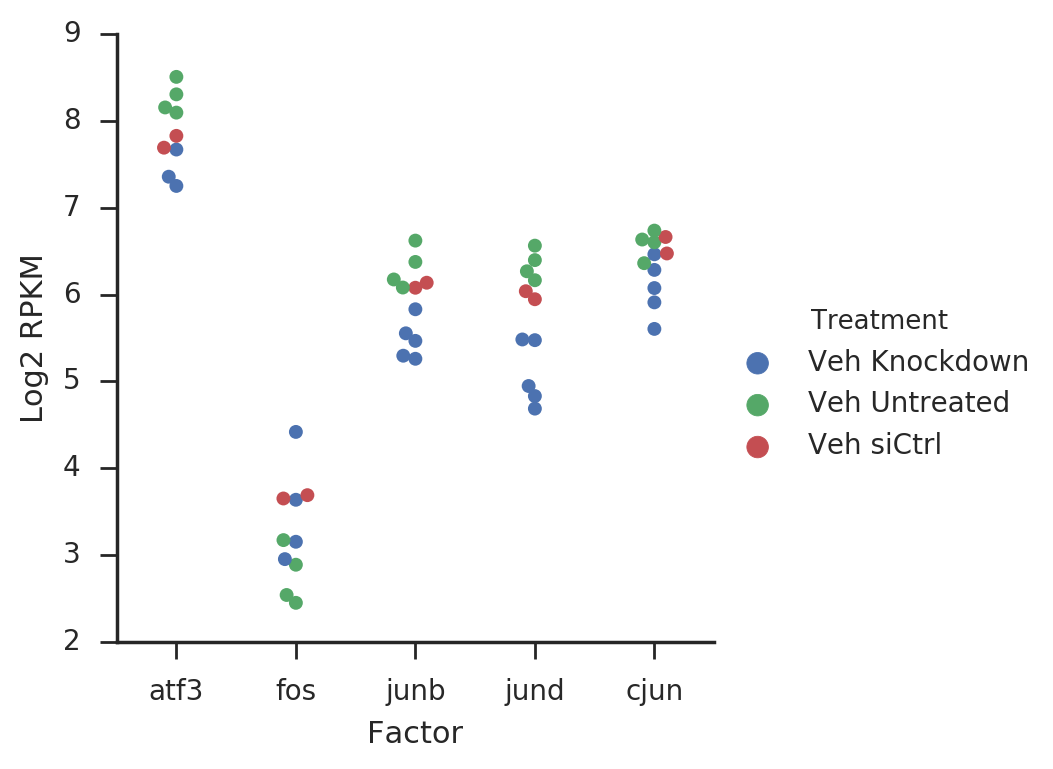

In [196]:
with sns.axes_style('ticks'):
    data = plotting_frame[plotting_frame['Treatment'].str.contains('Veh')]
    sns.factorplot(data=data,
                   kind = 'swarm',
                   x = 'Factor',
                   y = 'Log2 RPKM',
                   hue = 'Treatment')

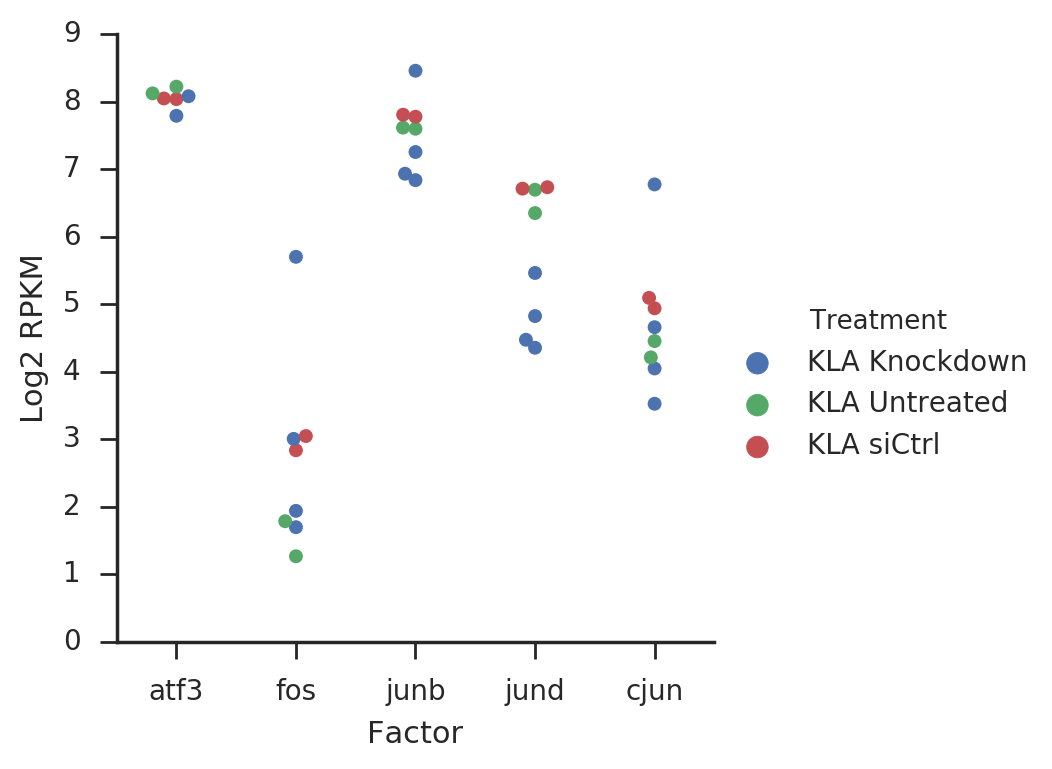

In [197]:
with sns.axes_style('ticks'):
    sns.factorplot(data = plotting_frame[plotting_frame['Treatment'].str.contains('KLA')],
               kind = 'swarm',
               x = 'Factor',
               y = 'Log2 RPKM',
               hue = 'Treatment')

In [201]:
samples

['C57Bl6_Thiomac_RNA_KLA-1h_UT_CR_12-03-09',
 'C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_14-12-15',
 'C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_15-04-06',
 'C57Bl6_Thiomac_RNA_KLA-6h_UT_GFEW_16-02-04',
 'C57Bl6_Thiomac_RNA_Veh_UT_VML_15-02-26',
 'C57Bl6_Thiomac_RNA_Veh_UT_TKS_14-12-15',
 'C57Bl6_Thiomac_RNA_Veh_UT_CR_12-03-09',
 'C57Bl6_Thiomac_RNA_Veh_UT_TKS_15-04-06',
 'C57Bl6_Thiomac_RNA_Veh_UT_GFEW_16-02-04',
 'C57Bl6_Thiomac_RNA_KLA-6h_siATF3_GJF_16-06-14',
 'C57Bl6_Thiomac_RNA_KLA-6h_siATF3_GFEW_16-02-04',
 'C57Bl6_Thiomac_RNA_Veh_siATF3_GJF_16-09-20',
 'C57Bl6_Thiomac_RNA_Veh_siATF3_GJF_16-06-14',
 'C57Bl6_Thiomac_RNA_Veh_siATF3_GFEW_16-02-04',
 'C57Bl6_Thiomac_RNA_KLA-6h_siCtrl_GJF_15-02-06',
 'C57Bl6_Thiomac_RNA_KLA-6h_siCtrl_GFEW_15-10-30',
 'C57Bl6_Thiomac_RNA_KLA-6h_siCtrl_GFEW_16-02-04',
 'C57Bl6_Thiomac_RNA_Veh_siCtrl_GJF_16-09-20',
 'C57Bl6_Thiomac_RNA_Veh_siCtrl_GFEW_16-02-04',
 'C57Bl6_Thiomac_RNA_Veh_siCtrl_GJF_15-02-06',
 'C57Bl6_Thiomac_RNA_Veh_siCtrl_GFEW_15-10-19',
 'C57Bl6_Thiomac

In [198]:
samples = raw_frame.columns[9:].values
samples = [x.replace('siCtrl_Veh','Veh_siCtrl') for x in samples]

filteredTagDirectories = ' '.join(['/home/jtao/analysis/ap1_analysis/tag_directories_rna/' +x for x in samples])

conditions = ['_'.join(x.split('_')[3:5]) for x in samples]
conditions = [x[:-3] if 'Ctrl' in x else x for x in conditions]
conditions = ' '.join(conditions)
!getDiffExpression.pl raw.tsv -AvsA $conditions > homer_diffExpresion.tsv






	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats KLA-1h_UT vs. KLA-6h_UT:
		Total Genes: 24453
		Total Up-regulated in KLA-6h_UT vs. KLA-1h_UT: 5 (0.020%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in KLA-6h_UT vs. KLA-1h_UT: 50 (0.204%) [log2fold<-1, FDR<0.05]
	Output Stats KLA-1h_UT vs. Veh_UT:
		Total Genes: 24453
		Total Up-regulated in Veh_UT vs. KLA-1h_UT: 38 (0.155%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in Veh_UT vs. KLA-1h_UT: 298 (1.219%) [log2fold<-1, FDR<0.05]
	Output Stats KLA-1h_UT vs. KLA-6h_siATF3:
		Total Genes: 24453
		Total Up-regulated in KLA-6h_siATF3 vs. KLA-1h_UT: 4 (0.016%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in KLA-6h_siATF3 vs. KLA-1h_UT: 28 (0.115%) [log2fold<-1, FDR<0.05]
	Output Stats KLA-1h_UT vs. Veh_siATF3:
		Total Genes: 24453
		Total Up-regulated in Veh_siATF3 vs. KLA-1h_UT: 883 (3.611%) [log2fold

In [199]:
diffExpression_frame = pd.read_csv('homer_diffExpresion.tsv', sep='\t')
columns = diffExpression_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_frame.columns=columns
diffExpression_frame['gene'] = [x.split('|')[0].upper() for x in diffExpression_frame['Divergence']]
diffExpression_frame.index = diffExpression_frame.gene.values
columns = ['refseq', 'gene'] + [x for x in diffExpression_frame.columns if 'vs.' in x]
diffExpression_frame = diffExpression_frame[columns]

*** Veh siATF3 ***
Veh_siATF3 vs. Veh_siCtrl 81 222
Veh_UT vs. Veh_siATF3 625 537
28 131
22 103
*** Veh siFos ***
Veh_siCtrl vs. Veh_siFos 0 0
Veh_UT vs. Veh_siFos 282 276
0 0
0 0
*** Veh siJunB ***
Veh_siCtrl vs. Veh_siJunB 1 45
Veh_UT vs. Veh_siJunB 399 417
1 19
1 18
*** Veh siJunD ***
Veh_siCtrl vs. Veh_siJunD 5 65
Veh_UT vs. Veh_siJunD 603 479
3 42
2 37
*** Veh sicJun ***
Veh_siCtrl vs. Veh_sicJun 6 40
Veh_UT vs. Veh_sicJun 393 355
3 24
2 22
*** KLA-6h siATF3 ***
KLA-6h_siATF3 vs. KLA-6h_siCtrl 1 101
KLA-6h_UT vs. KLA-6h_siATF3 1 3
0 1
0 0
*** KLA-6h siFos ***
KLA-6h_siCtrl vs. KLA-6h_siFos 0 23
KLA-6h_UT vs. KLA-6h_siFos 1 1
0 0
0 0
*** KLA-6h siJunB ***
KLA-6h_siCtrl vs. KLA-6h_siJunB 1 43
KLA-6h_UT vs. KLA-6h_siJunB 0 0
0 0
0 0
*** KLA-6h siJunD ***
KLA-6h_siCtrl vs. KLA-6h_siJunD 2 19
KLA-6h_UT vs. KLA-6h_siJunD 0 1
0 0
0 0
*** KLA-6h sicJun ***
KLA-6h_siCtrl vs. KLA-6h_sicJun 0 54
KLA-6h_UT vs. KLA-6h_sicJun 0 1
0 0
0 0


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

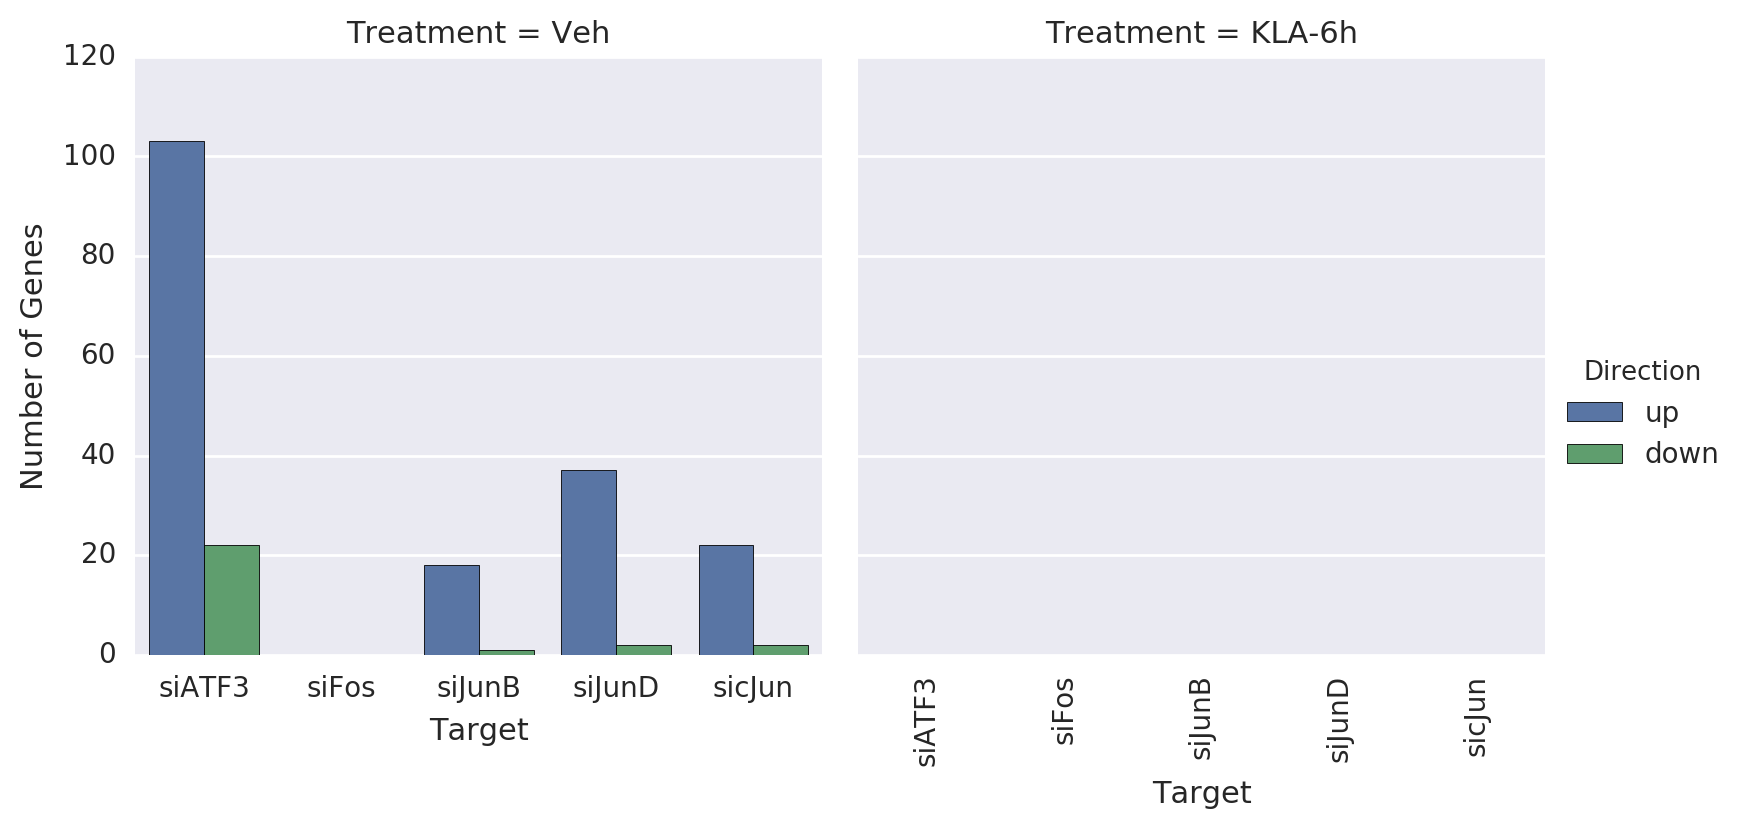

In [200]:
fold_threshold = np.log2(1) # magnitude of cutoff to use for diff expressed genes
p_threshold = 0.05 # FDR adjusted p-value threshold

condition_genes_up_dict = {} # {treatment_target:set(genes)}
condition_genes_down_dict = {} # {treatment_target:set(genes)}

condition_genes_up_control_dict = {} # {treatment_target:set(genes)}
condition_genes_down_control_dict = {} # {treatment_target:set(genes)}

condition_genes_up_untreated_dict = {} # {treatment_target:set(genes)}
condition_genes_down_untreated_dict = {} # {treatment_target:set(genes)}

directions = []
numGenes = []
treatments = []
kd_targets = []

targets = [x for x in sorted(set(filtered_summary_frame_rna['target'])) if not 'UT' in x and not 'Ctrl' in x]
columns = diffExpression_frame.columns.values
for treatment in ['Veh', 'KLA-6h']:
    untreated_condition = treatment + '_UT'
    control_condition = treatment + '_siCtrl'
    for target in targets:
        # figure out which columns to use in EdgeR results
        target_condition = treatment + '_' + target
        if target_condition + ' vs. ' + untreated_condition + ' adj. p-value' in columns:
            untreated_comparison = target_condition + ' vs. ' + untreated_condition
            untreated_first = False
        elif untreated_condition + ' vs. ' + target_condition + ' adj. p-value' in columns:
            untreated_comparison = untreated_condition + ' vs. ' + target_condition
            untreated_first = True

        if target_condition + ' vs. ' + control_condition + ' adj. p-value' in columns:
            control_comparison = target_condition + ' vs. ' + control_condition
            control_first = False
        elif control_condition + ' vs. ' + target_condition + ' adj. p-value' in columns:
            control_comparison = control_condition + ' vs. ' + target_condition
            control_first = True

        # compute down and up-regulated genes
        if untreated_first:
            up_untreated_genes = diffExpression_frame[
                                 (diffExpression_frame[untreated_comparison + ' Log2 Fold Change'] >= fold_threshold) &
                                 (diffExpression_frame[untreated_comparison + ' adj. p-value'] <= p_threshold) ].index.values
            down_untreated_genes = diffExpression_frame[
                                 (diffExpression_frame[untreated_comparison + ' Log2 Fold Change'] <= -1*fold_threshold) &
                                 (diffExpression_frame[untreated_comparison + ' adj. p-value'] <= p_threshold) ].index.values
        else:
            down_untreated_genes = diffExpression_frame[
                                 (diffExpression_frame[untreated_comparison + ' Log2 Fold Change'] >= fold_threshold) &
                                 (diffExpression_frame[untreated_comparison + ' adj. p-value'] <= p_threshold)].index.values
            up_untreated_genes = diffExpression_frame[
                                 (diffExpression_frame[untreated_comparison + ' Log2 Fold Change'] <= -1*fold_threshold) &
                                 (diffExpression_frame[untreated_comparison + ' adj. p-value'] <= p_threshold)].index.values

        if control_first:
            up_control_genes = diffExpression_frame[
                                 (diffExpression_frame[control_comparison + ' Log2 Fold Change'] >= fold_threshold) &
                                 (diffExpression_frame[control_comparison + ' adj. p-value'] <= p_threshold)].index.values
            down_control_genes = diffExpression_frame[
                                 (diffExpression_frame[control_comparison + ' Log2 Fold Change'] <= -1*fold_threshold) &
                                 (diffExpression_frame[control_comparison + ' adj. p-value'] <= p_threshold)].index.values
        else:
            down_control_genes = diffExpression_frame[
                                 (diffExpression_frame[control_comparison + ' Log2 Fold Change'] >= fold_threshold) &
                                 (diffExpression_frame[control_comparison + ' adj. p-value'] <= p_threshold)].index.values
            up_control_genes = diffExpression_frame[
                                 (diffExpression_frame[control_comparison + ' Log2 Fold Change'] <= -1*fold_threshold) &
                                 (diffExpression_frame[control_comparison + ' adj. p-value'] <= p_threshold)].index.values
         
        # convert numpy arrays to sets
        up_untreated_genes = set(up_untreated_genes)
        down_untreated_genes = set(down_untreated_genes)
        up_control_genes = set(up_control_genes)
        down_control_genes = set(down_control_genes)
        
        # filter away genes that aren't expressed
        expressed_genes = set(idr_rpkm_mean_frame[idr_rpkm_mean_frame[[target_condition, 
                             untreated_condition, 
                             control_condition]].max(axis=1) >= 4].index.values)
        down_control_genes = down_control_genes.intersection(expressed_genes)
        up_control_genes = up_control_genes.intersection(expressed_genes)
        down_untreated_genes = down_untreated_genes.intersection(expressed_genes)
        up_untreated_genes = up_untreated_genes.intersection(expressed_genes)
        
        condition_genes_down_control_dict[target_condition] = down_control_genes
        condition_genes_up_control_dict[target_condition] = up_control_genes
        
        condition_genes_down_untreated_dict[target_condition] = down_untreated_genes
        condition_genes_up_untreated_dict[target_condition] = up_untreated_genes
        
        print('***', treatment, target, '***')
        print(control_comparison, len(down_control_genes), len(up_control_genes))
        print(untreated_comparison, len(down_untreated_genes), len(up_untreated_genes))
        # calculate intersection of genes
        down_genes = down_untreated_genes.intersection(down_control_genes)
        up_genes = up_untreated_genes.intersection(up_control_genes)
        
        # filter away genes that are affected by the siCtrl
        print(len(down_genes),len(up_genes))
        if treatment == 'Veh':
            down_genes = down_genes - siCtrl_veh_genes
            up_genes = up_genes - siCtrl_veh_genes
        else:
            down_genes = down_genes - siCtrl_kla_genes
            up_genes = up_genes - siCtrl_kla_genes
        
        print(len(down_genes), len(up_genes))
            
        condition_genes_up_dict[target_condition] = up_genes
        condition_genes_down_dict[target_condition] = down_genes
        
        kd_targets = kd_targets + [target] * 2
        directions = directions + ['up', 'down']
        treatments = treatments + [treatment] * 2
        numGenes.append(len(up_genes))
        numGenes.append(len(down_genes))

frame = pd.DataFrame({'Target':kd_targets,
                      'Treatment':treatments,
                      'Direction':directions,
                      'Number of Genes':numGenes})
sns.factorplot(data=frame, 
               kind='bar',
               x='Target',
               y='Number of Genes',
               hue = 'Direction',
               col='Treatment')
plt.xticks(rotation=90)

## Heatmap

In [ ]:
veh_diff_genes = set()
kla_diff_genes = set()
for key in condition_genes_down_dict.keys():
    if 'Veh' in key:
        veh_diff_genes = veh_diff_genes.union(condition_genes_down_dict[key])
        veh_diff_genes = veh_diff_genes.union(condition_genes_up_dict[key])
    if 'KLA' in key:
        kla_diff_genes = kla_diff_genes.union(condition_genes_down_dict[key])
        kla_diff_genes = kla_diff_genes.union(condition_genes_up_dict[key])

In [ ]:
# vehicle fold change
data = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(veh_diff_genes)]\
    [[x for x in idr_rpkm_mean_frame.columns if 'Veh' in x]]
    
# normalize by control experiment
data = (data+0.1).div((data['Veh_siCtrl'].values+0.1), axis=0)

# drop control and UT columns
data = data[[x for x in data.columns if not 'UT' in x and not 'Ctrl' in x]]
sns.clustermap(np.log2(data),
              yticklabels=False,
              cmap='coolwarm',
              col_cluster=False,
              vmin = -1,
              vmax=1)

In [ ]:
# KLA fold change
data = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(kla_diff_genes)]\
    [[x for x in idr_rpkm_mean_frame.columns if 'KLA' in x]]
    
# normalize by control experiment
data = (data+0.1).div((data['KLA-6h_siCtrl'].values+0.1), axis=0)

# drop control and UT columns
data = data[[x for x in data.columns if not 'UT' in x and not 'Ctrl' in x]]
sns.clustermap(np.log2(data),
              yticklabels=False,
              cmap='coolwarm',
              vmin = -1,
              col_cluster=False,
              vmax=1)

## Gene Ontology

In [ ]:
! if [ ! -d ./gene_ontology ]; then mkdir ./gene_ontology/ ; else rm ./gene_ontology/* ;fi

In [ ]:
# write genes for gene ontology
# back ground genes
background_file = open('./gene_ontology/background.txt','w')
expressed_genes = idr_rpkm_mean_frame[idr_rpkm_mean_frame.max(axis=1) >= 4].index.values
for gene in sorted(expressed_genes):
    background_file.write(gene.upper() + '\n')
background_file.close()
    
# down regulated genes
for condition in sorted(condition_genes_down_dict.keys()):
    down_file = open('./gene_ontology/' + condition + '_down.txt', 'w')
    
    down_genes = sorted(condition_genes_down_dict[condition])
    for g in down_genes:
        down_file.write(g.upper() + '\n')
    print(condition, len(down_genes),'down')
    down_file.close()

# upregulated genes
for condition in sorted(condition_genes_up_dict.keys()):
    up_file = open('./gene_ontology/' + condition + '_up.txt', 'w')
    
    up_genes = sorted(condition_genes_up_dict[condition])
    for g in up_genes:
        up_file.write(g.upper() + '\n')
    up_file.close()
    print(condition, len(up_genes),'up')

In [ ]:
for f in os.listdir('./gene_ontology/'):
    if not 'background' in f and not 'result' in f and 'txt' in f:
        out_name = f.replace('.txt', '_result.txt')
#         os.system('/bioinformatics/software/anaconda2.7/bin/python2 /home/jtao/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/' 
#                   + f +' ./gene_ontology/background.txt /home/jtao/analysis/go_analysis/mouse_association --pval=0.05 > ./gene_ontology/' + out_name)
#         print('/bioinformatics/software/anaconda2.7/bin/python2 /home/jtao/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/' 
#                   + f +' ./gene_ontology/background.txt mouse_association --pval=0.05 > ./gene_ontology/' + out_name + ' &')
        print('/bioinformatics/software/anaconda2.7/bin/python2 /home/jtao/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/' 
                  + f +' ./gene_ontology/background.txt mouse_association --pval=1.0 > ./gene_ontology/' + out_name + ' &')




In [ ]:
term_tuples = []
terms = []
treatments = []

for f in sorted(os.listdir('./gene_ontology/')):
    if 'result' in f and 'up' in f and 'txt' in f :
        with open('./gene_ontology/' + f) as data:
            data = data.readlines()
        if len(data):
            results = pd.read_csv('./gene_ontology/' + f ,sep='\t', skiprows=2)
            treatment = '_'.join(f.split('_')[:-1])
            
            treatments.append(treatment)
            # seperate enriched and purified results
            enriched_results = results[results['enrichment']=='e']

            purified_results= results[results['enrichment']=='p']
            
            terms = terms + list(enriched_results['description'].values)
            
            term_tuples = term_tuples +list(zip(enriched_results['id'].values,
                                                enriched_results['description'].values, 
                                                enriched_results['p_' + 'uncorrected'].values, 
                                                [treatment] * enriched_results.shape[0]))
            
            
            print(treatment, enriched_results.shape)


terms = sorted(set(terms))
treatments=sorted(treatments)

term_id_dict = dict(zip([x[1] for x in term_tuples],
                       [x[0] for x in term_tuples]))
term_index_dict = dict(zip(terms, range(len(terms))))

treatment_index_dict = dict(zip(treatments, range(len(treatments))))
counter = 0
matrix = np.ones((len(terms), len(treatments)))
for t in term_tuples:
    matrix[term_index_dict[t[1]]][treatment_index_dict[t[3]]] = t[2]
up_frame = pd.DataFrame(matrix, columns=treatments, index=terms)
up_frame['id'] = [term_id_dict[x] for x in up_frame.index.values]


term_tuples = []
terms = []
treatments = []
for f in os.listdir('./gene_ontology/'):
    if 'result' in f and 'down' in f:
        with open('./gene_ontology/' + f) as data:
            data = data.readlines()
        if len(data):
            results = pd.read_csv('./gene_ontology/' + f ,sep='\t', skiprows=2)
            treatment = '_'.join(f.split('_')[:-1])
            treatments.append(treatment)

            # seperate enriched and purified results
            enriched_results = results[results['enrichment']=='e']

            purified_results= results[results['enrichment']=='p']
            
            terms = terms + list(enriched_results['description'].values)
            term_tuples = term_tuples +list(zip(enriched_results['id'].values,
                                                enriched_results['description'].values, 
                                                enriched_results['p_' + 'uncorrected'].values,  
                                                [treatment] * enriched_results.shape[0]))
            print(treatment, enriched_results.shape)


terms = sorted(list(set(terms)))
treatments=sorted(treatments)

term_id_dict = dict(zip([x[1] for x in term_tuples],
                       [x[0] for x in term_tuples]))
term_index_dict = dict(zip(terms, range(len(terms))))

treatment_index_dict = dict(zip(treatments, range(len(treatments))))

matrix = np.ones((len(terms), len(treatments)))
for t in term_tuples:
    matrix[term_index_dict[t[1]]][treatment_index_dict[t[3]]] = t[2]
down_frame = pd.DataFrame(matrix, columns=treatments, index=terms)
down_frame['id'] = [term_id_dict[x] for x in down_frame.index.values]

# save go terms
up_frame.to_csv('./gene_ontology/go_terms_up.tsv', sep='\t')
down_frame.to_csv('go_terms_down.tsv', sep='\t')
out_file = open('go_ids_up.txt', 'w')
for id in up_frame['id'].values:
    out_file.write(id.strip() + '\n')
out_file.close()

out_file = open('./gene_ontology/go_ids_down.txt', 'w')
for id in down_frame['id'].values:
    out_file.write(id.strip() + '\n')
out_file.close()

In [ ]:
# correct gene ontology p-values
p_threshold = 0.05
# bonferonni correction
# corrected_up_frame = up_frame.ix[:,:-1] * up_frame.shape[0] 
# corrected_down_frame = down_frame.ix[:,:-1] * down_frame.shape[0]
corrected_up_frame = up_frame 
corrected_down_frame = down_frame

# filter away genes that are insignficant
corrected_up_frame = corrected_up_frame[corrected_up_frame.min(axis=1) < p_threshold]
corrected_down_frame = corrected_down_frame[corrected_down_frame.min(axis=1) < p_threshold]

# ceil values greater than 1
# corrected_up_frame[corrected_up_frame > 1.0] = 1.0
# corrected_down_frame[corrected_down_frame > 1.0] = 1.0

In [ ]:
# down regulated genes
p_threshold = 0.00001
# vehicle
data = corrected_down_frame.ix[:,[x for x in corrected_down_frame.columns if not 'id' in x and not 'KLA' in x]]
data = data[data.min(axis=1) < p_threshold]
print(data.shape)
cg = sns.clustermap(-1*np.log10(data),
                   )
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

# # KLA
# data = corrected_down_frame.ix[:,[x for x in corrected_down_frame.columns if not 'id' in x and not 'Veh' in x]]
# data = data[data.min(axis=1) < p_threshold]
# print(data.shape)
# cg = sns.clustermap(-1*np.log10(data),
#                    )
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

In [ ]:
# up-regulated genes 
p_threshold = 0.0001
# vehicle
data = corrected_up_frame.ix[:,[x for x in corrected_up_frame.columns if not 'id' in x and not 'KLA' in x]]
data = data[data.min(axis=1) < p_threshold]
cg = sns.clustermap(-1*np.log10(data),
                   )
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

# KLA

data = corrected_up_frame.ix[:,[x for x in corrected_up_frame.columns if not 'id' in x and not 'Veh' in x]]
data = data[data.min(axis=1) < p_threshold]
cg = sns.clustermap(-1*np.log10(data),
                   )
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, size=8);

## PCA

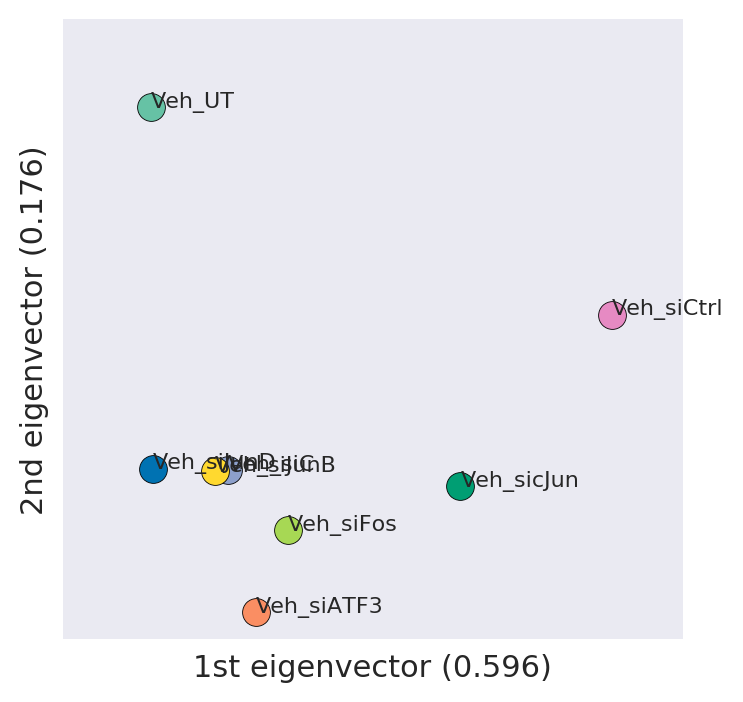

In [205]:
# vehicle genes
plt.figure(figsize=(4,4))
# features = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(veh_diff_genes)]\
#     [[x for x in idr_rpkm_mean_frame.columns if 'Veh' in x and not 'UT' in x and not 'Ctrl' in x]]
features = idr_rpkm_mean_frame[[x for x in idr_rpkm_mean_frame.columns if 'Veh' in x ]]
# features = idr_rpkm_mean_frame[['Veh_sicJun', 'Veh_siFos','Veh_siJunB', 'Veh_siJunD']]
classes = features.columns.values

colorDict = dict(zip(sorted(set(classes)), 
                 sns.color_palette("Set2") + sns.color_palette("colorblind")))


model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(features.T)
explained_variance_ratios = model.explained_variance_ratio_

colors = [colorDict[x] for x in features.columns.values]

for i in range(len(classes)):
    plt.scatter(reduced_features[i, 0], reduced_features[i, 1], 
                s=100, 
                c=colors[i],
                label=classes[i])
    plt.annotate(classes[i],xy=(reduced_features[i, 0], reduced_features[i, 1]), size=8)
plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])
ax = plt.gca()

x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0)) 

plt.show()



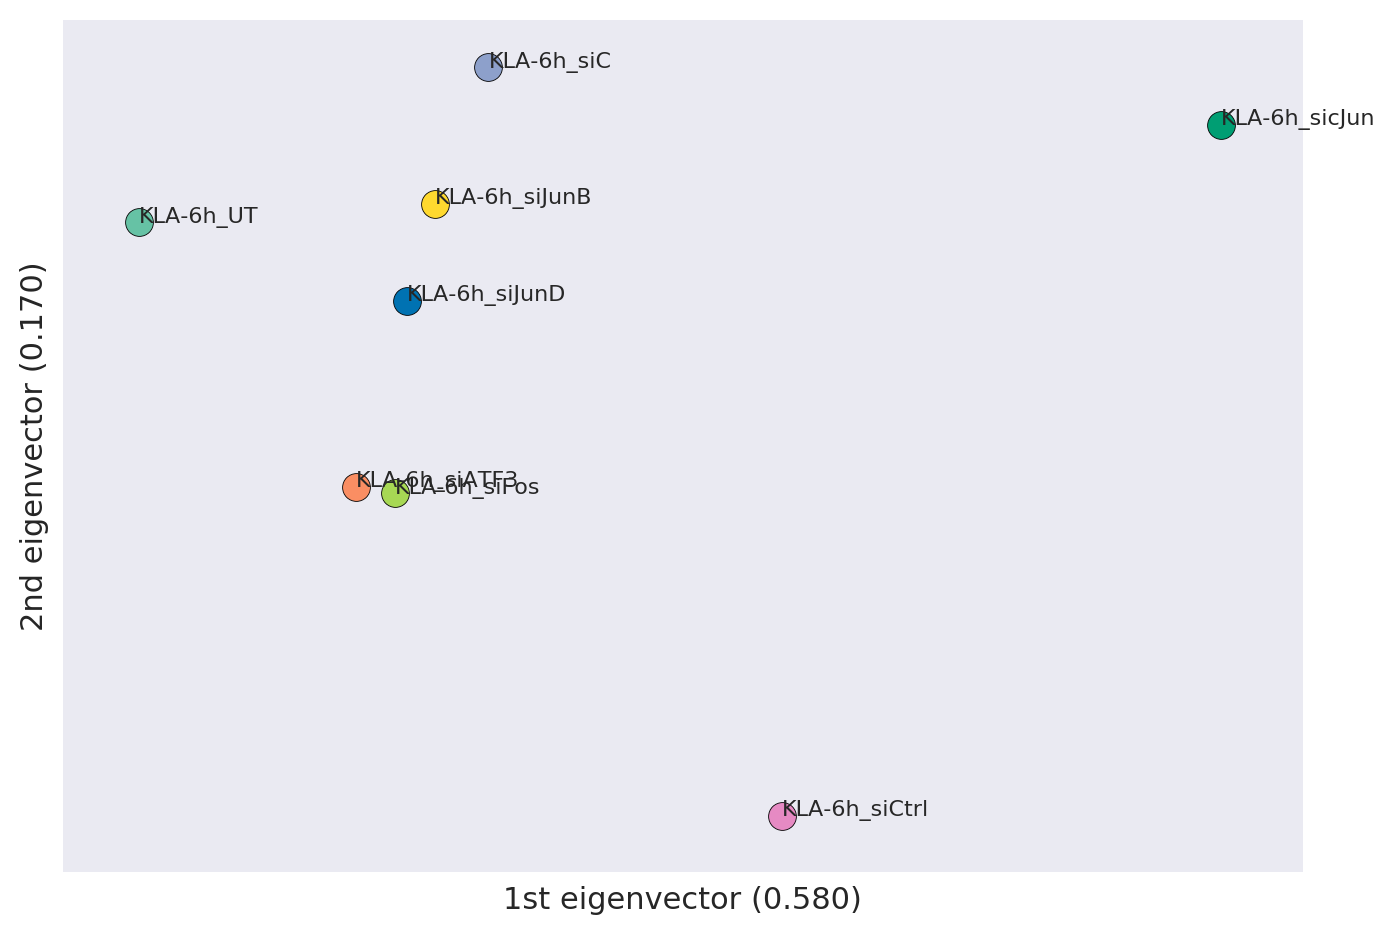

In [206]:
# KLA genes

# features = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(veh_diff_genes)]\
#     [[x for x in idr_rpkm_mean_frame.columns if 'KLA' in x and not 'UT' in x and not 'Ctrl' in x]]
features = idr_rpkm_mean_frame[[x for x in idr_rpkm_mean_frame.columns if 'KLA' in x and not '1h' in x]]
# features = idr_rpkm_mean_frame[['KLA-6h_sicJun', 'KLA-6h_siFos','KLA-6h_siJunB', 'KLA-6h_siJunD']]
classes = features.columns.values

colorDict = dict(zip(sorted(set(classes)), 
                 sns.color_palette("Set2") + sns.color_palette("colorblind")))


model = sklearn.decomposition.PCA(n_components=2)
reduced_features = model.fit_transform(features.T)
explained_variance_ratios = model.explained_variance_ratio_

colors = [colorDict[x] for x in features.columns.values]

for i in range(len(classes)):
    plt.scatter(reduced_features[i, 0], reduced_features[i, 1], 
                s=100, 
                c=colors[i], label=classes[i])
    plt.annotate(classes[i],xy=(reduced_features[i, 0], reduced_features[i, 1]), size=8)


plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])

# plt.legend()
ax = plt.gca()


# ax.set_aspect(explained_variance_ratios[1]/explained_variance_ratios[0])
plt.show()




## Scatter Plots

In [ ]:
fdr_threshold = 0.05
fold_threshold = 2
rpkm_cutoff = 4.0
label_fold_threshold = 6
# specific genes to annotate no matter what
target_genes = []
target_genes = [x.upper() for x in target_genes]

sns.set_style('ticks',{'axes.edgecolor': 'black',
                       'xtick.direction': 'in',
                       'ytick.direction': 'in', 
                         })

! rm ./scatter_plots/*



if not os.path.isdir('./scatter_plots'):
    os.mkdir('./scatter_plots/')
treatment_up_dict = {}
treatment_down_dict = {}
   

   
fdrColumns = [x for x in diffExpression_frame.columns if 'adj.' in x and 'Ctrl' in x]


for c in fdrColumns:
        tokens = c.split()
        if ('veh' in tokens[0].lower() and 'veh' in tokens[2].lower()) or ('kla' in tokens[0].lower() and 'kla' in tokens[2].lower()):
            if 'ctrl' in tokens[0].lower():
                treatment1 = tokens[0]
                treatment2 = tokens[2]
            else:
                treatment1 = tokens[2]
                treatment2 = tokens[0]

            fc_column = c.replace('adj. p-value', 'Log2 Fold Change')

            diff_genes = diffExpression_frame[diffExpression_frame[c] < fdr_threshold]['gene'].values

            reads1 = idr_rpkm_mean_frame[treatment1]
            reads2 = idr_rpkm_mean_frame[treatment2]
            all_genes = idr_rpkm_frame.index.values
            read_tuple_list = tuple(zip(all_genes, reads1, reads2))
            filtered_read_tuple_list = [x for x in read_tuple_list if x[1] >= rpkm_cutoff or x[2]>= rpkm_cutoff ]

            filtered_genes = [x[0] for x in filtered_read_tuple_list]
            reads1 = np.array([x[1] for x in filtered_read_tuple_list])
            reads2 = np.array([x[2] for x in filtered_read_tuple_list])
             # log values
            logged_reads1 = np.log2(reads1 + 0.01)
            logged_reads2 = np.log2(reads2 + 0.01)

            label_x = []
            label_y = []
            fold_genes = []
            colors = []
            for i in range(len(filtered_genes)): 
                fold = (reads1[i]+0.000001)/(reads2[i]+0.0000001)

                if fold >=fold_threshold or fold <=1/fold_threshold:
                    fold_genes.append(filtered_genes[i])
                    label_x.append(logged_reads1[i])
                    label_y.append(logged_reads2[i])
                    colors.append('blue')
                elif filtered_genes[i].upper() in target_genes:
                    fold_genes.append(filtered_genes[i])
                    label_x.append(logged_reads1[i])
                    label_y.append(logged_reads2[i])
                    colors.append('red')
                else:
                    colors.append('red')

            # ensure diff diff expressed genes are on top
            val_tuples = tuple(zip(logged_reads1,logged_reads2,colors))
            sorted_tuples = sorted(val_tuples,key=lambda x: x[2], reverse=True)
            logged_reads1 = [x[0] for x in sorted_tuples] 
            logged_reads2 = [x[1] for x in sorted_tuples]
            colors = [x[2] for x in sorted_tuples]
            plt.figure(figsize=(2,2))
            plt.scatter(logged_reads1, logged_reads2, edgecolors='none', c=colors, marker = '.', s=15)
            ### annotate differentially expressed genes

            for label, x, y in zip(fold_genes, label_x, label_y):
                fold = (x+0.000001)/(y+0.0000001)
                if fold >=label_fold_threshold or fold <=1/label_fold_threshold:
                    plt.annotate(
                        label, 
                        xy = (x, y),
                        size=4)

            sns.despine()
            # fix aspect ratio
            ax = plt.gca()
            ax.set_xlim((0,12))
            ax.set_ylim((0,12))
            x0,x1 = ax.get_xlim()
            y0,y1 = ax.get_ylim()
            ax.set_aspect(abs(x1-x0)/abs(y1-y0))        
            plt.xlabel(treatment1 + ' log2 rpkm')
            plt.ylabel(treatment2 + ' log2 rpkm')
            plt.savefig('./scatter_plots/'+ treatment1 + '_' + treatment2 + '_logRPKM_scatter.png', bbox_inches='tight')
            plt.savefig('./scatter_plots/'+ treatment1 + '_' + treatment2 + '_logRPKM_scatter.pdf', bbox_inches='tight')
            plt.show()
            
        

## Venn Diagrams

In [ ]:
import networkx as nx
current_palette = sns.color_palette()



### Vehicle

In [ ]:
count_threshold = 2

targets = [x for x in sorted(set(filtered_summary_frame_rna['target'])) if not 'UT' in x and not 'Ctrl' in x]
targets.remove('siATF3')

# get genes affected by n or more knockouts
gene_count_down_dict = {}
gene_count_up_dict = {}

for target in targets:
    # down-regulated genes
    down_genes = condition_genes_down_dict['Veh_' + target]
    for g in down_genes:
        if g in gene_count_down_dict:
            gene_count_down_dict[g] += 1
        else:
            gene_count_down_dict[g] = 1
    # up-regulated genes
    up_genes = condition_genes_up_dict['Veh_' + target]
    for g in down_genes:
        if g in gene_count_up_dict:
            gene_count_up_dict[g] += 1
        else:
            gene_count_up_dict[g] = 1
            
countFiltered_down_genes = [x for x in list(gene_count_down_dict.keys()) if gene_count_down_dict[x] >= count_threshold]
countFiltered_up_genes = [x for x in list(gene_count_up_dict.keys())if gene_count_up_dict[x] >= count_threshold]

# create network
network = nx.Graph()
down_edges = []
up_edges = []
for target in targets:
    down_genes = condition_genes_down_dict['Veh_' + target]
    for g in down_genes:
        if g in countFiltered_down_genes:
            network.add_edge(target, g, direction='down', weight=1)
            down_edges.append((target,g))
            
    up_genes = condition_genes_up_dict['Veh_' + target]
    for g in up_genes:
        if g in countFiltered_up_genes:
            network.add_edge(target, g, direction='up', weight=1)
            up_edges.append((target,g))
        
    

In [ ]:
maxDegree = 4
spacing_factor = 4


color_dict = dict(zip(range(1,maxDegree+1),sns.color_palette('Greens',maxDegree)))

with sns.axes_style('whitegrid'):
    # pos = nx.spring_layout(network,
    #                        k=spacing_factor/np.sqrt(len(network)),# spacing between nodes
    #                       )
    pos = nx.nx_agraph.graphviz_layout(network, prog='neato',root=None, args='-Goverlap=false')

    d = nx.degree(network)
    plt.figure(figsize=(16,16))
    nx.draw_networkx_nodes(network,
                           pos,
                           with_labels=False,
                           nodelist=d.keys(),
    #                        node_size = [500 if v in targets else 4**d[v] for v in d.keys()],
                           node_size = [3000 if v in targets else 1500 for v in d.keys()],
                           node_color = ['lightblue' if v in targets else color_dict[d[v]] for v in d.keys()],

                            )

    nx.draw_networkx_edges(network,
                           pos,
                           edgelist= down_edges,
                           edge_color='blue',
                           width=0.5)

    nx.draw_networkx_edges(network,
                           pos,
                           edgelist= up_edges,
                           edge_color='red',
                           width=0.5)

    nx.draw_networkx_labels(network, pos, 
#                             dict(zip(d.keys(),[v if v in targets else "" for v in d.keys()])),
                            font_size= 10
                            )

#     nx.write_gml(network,'/home/jtao/analysis/ap1_rna_analysis/vehicle.gml')
    # nx.write_edgelist(network,'/home/jtao/analysis/ap1_rna_analysis/vehicle_edges.tsv')

    plt.xticks([])
    plt.yticks([])
    plt.axis('equal')
    plt.savefig('./vehicle_network.png')

In [ ]:
for g in condition_genes_down_dict['Veh_siJunD'].intersection(condition_genes_down_dict['Veh_siFos']):
    print(g)

In [ ]:
for g in list(network.nodes()):
    if not 'si' in g:
        print(g)

### KLA Network

In [ ]:
count_threshold = 1

targets = [x for x in sorted(set(filtered_summary_frame_rna['target'])) if not 'UT' in x and not 'Ctrl' in x]
targets.remove('siATF3')

# get genes affected by n or more knockouts
gene_count_down_dict = {}
gene_count_up_dict = {}

for target in targets:
    # down-regulated genes
    down_genes = condition_genes_down_dict['KLA-6h_' + target]
    for g in down_genes:
        if g in gene_count_down_dict:
            gene_count_down_dict[g] += 1
        else:
            gene_count_down_dict[g] = 1
    # up-regulated genes
    up_genes = condition_genes_up_dict['KLA-6h_' + target]
    for g in down_genes:
        if g in gene_count_up_dict:
            gene_count_up_dict[g] += 1
        else:
            gene_count_up_dict[g] = 1
            
countFiltered_down_genes = [x for x in list(gene_count_down_dict.keys()) if gene_count_down_dict[x] >= count_threshold]
countFiltered_up_genes = [x for x in list(gene_count_up_dict.keys())if gene_count_up_dict[x] >= count_threshold]



# create network
network = nx.Graph()
down_edges = []
up_edges = []
for target in targets:
    down_genes = condition_genes_down_dict['KLA-6h_' + target]
    for g in down_genes:
        if g in countFiltered_down_genes:
            network.add_edge(target, g, direction='down', weight=1)
            down_edges.append((target,g))
            
    up_genes = condition_genes_up_dict['KLA-6h_' + target]
    for g in up_genes:
        if g in countFiltered_up_genes:
            network.add_edge(target, g, direction='up', weight=1)
            up_edges.append((target,g))
        

In [ ]:
network.degree()

In [ ]:
maxDegree = 4
spacing_factor = 4


color_dict = dict(zip(range(1,maxDegree+1),sns.color_palette('Greens',maxDegree)))

with sns.axes_style('whitegrid'):
    # pos = nx.spring_layout(network,
    #                        k=spacing_factor/np.sqrt(len(network)),# spacing between nodes
    #                       )
    pos = nx.nx_agraph.graphviz_layout(network, prog='neato',root=None, args='-Goverlap=false')

    d = nx.degree(network)
    plt.figure(figsize=(16,16))
    nx.draw_networkx_nodes(network,
                           pos,
                           with_labels=False,
                           nodelist=d.keys(),
    #                        node_size = [500 if v in targets else 4**d[v] for v in d.keys()],
                           node_size = [3000 if v in targets else 1500 for v in d.keys()],
                           node_color = ['lightblue' if v in targets else color_dict[d[v]] for v in d.keys()],

                            )

    nx.draw_networkx_edges(network,
                           pos,
                           edgelist= down_edges,
                           edge_color='blue',
                           width=0.5)

    nx.draw_networkx_edges(network,
                           pos,
                           edgelist= up_edges,
                           edge_color='red',
                           width=0.5)

    nx.draw_networkx_labels(network, pos, 
#                             dict(zip(d.keys(),[v if v in targets else "" for v in d.keys()])),
                            font_size= 10
                            )

#     nx.write_gml(network,'/home/jtao/analysis/ap1_rna_analysis/vehicle.gml')
    # nx.write_edgelist(network,'/home/jtao/analysis/ap1_rna_analysis/vehicle_edges.tsv')

    plt.xticks([])
    plt.yticks([])
    plt.axis('equal')
    plt.savefig('./kla_network.png')